<a href="https://colab.research.google.com/github/Crippius/active_learning_project/blob/main/active_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports, Initializations and Setup

In [1]:
%%capture
!pip install sentence_transformers

In [2]:
%%capture

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.class_weight import compute_class_weight
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import euclidean
from sklearn.manifold import TSNE
from IPython.display import display
from google.colab import drive
from math import pow, sqrt
import random
import time


drive.mount('/content/drive')

In [3]:
# Choose which dataset to use between "casualty" | "damage" | "weapons"
LABEL = "casualty"
SAMPLE = 222_000

df = pd.read_pickle(f"/content/drive/MyDrive/Uni/Terzo anno/Progetto di Ingegneria Informatica/code/{LABEL}.pickle")
if SAMPLE < len(df):
  df = df.sample(SAMPLE)

In [4]:
# Choose which embedding method to use between "fast" | "precise"
EMBEDDING_TYPE = "fast"


types_of_embedding = {"fast":{"name":"all-MiniLM-L6-v2", "dim":384},
                   "precise":{"name":"all-mpnet-base-v2", "dim":768}}

EMBEDDING_MODEL = SentenceTransformer(types_of_embedding[EMBEDDING_TYPE]["name"])
EMBEDDING_DIMENSION = types_of_embedding[EMBEDDING_TYPE]["dim"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Thresholds
DECISION_THRESHOLD = 0.5
CLASSIFICATION_THRESHOLD = 0.1

def decision(cnn_output):
  return cnn_output > DECISION_THRESHOLD

def classify(label):
  return label > CLASSIFICATION_THRESHOLD


In [6]:
# Neural network configurations
BUDGET = 1000
# Choose between "random" | "farthest_first" | "minimax"
AL_METHOD = "minimax"
# Choose between "optimal" | "normal" | "forgetful"
AL_EFFICIENCY = "normal"

EPOCHS = 12
BATCH_SIZE = 32
TRAIN_RATIO = 0.80
LEARNING_RATE = 1e-3
VALIDATION_RATIO = 1-TRAIN_RATIO

In [7]:
# Additional analysis
EXECUTE_EMBEDDING = False
CHECK_POSITION = False
BEST_SCENARIO = True

In [8]:
# Seed initialization
SEED = 42


np.random.seed(SEED)
tf.random.set_seed(SEED)

## Dataset study


Example of Tweet

In [9]:
print("Example of tweet")
x = df.sample()
x

Example of tweet


,tid,cid,text,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean,ts,tid_str,casualty,embedding
308530,1497143555046866945,1.497144e+18,Football has moved fast and stripped Russia of...,0.0,0.0,5.0,0,0.0,Football has moved fast and stripped Russia of...,2022-02-25 09:36:53.762,1497143555046866945,0.0,"(-0.002878740895539522, 0.10048303753137589, -..."


In [10]:
print(x.iloc[0].text_clean)

Football has moved fast and stripped Russia of the Champions League final. Mounting pressure now on F1 to abandon Sochi. F1 F1Testing


In [11]:
print(f"Example of tweet (possibly) talking about {LABEL}")
x = df[df[LABEL] == 1.0].sample()
x

Example of tweet (possibly) talking about casualty


,tid,cid,text,retweet_count,reply_count,like_count,quote_count,impression_count,text_clean,ts,tid_str,casualty,embedding
137341,1496777844755603459,1.496778e+18,Not everyday that you have a mid-air turn back...,113.0,35.0,818.0,5,0.0,Not everyday that you have a mid-air turn back...,2022-02-24 09:23:41.634,1496777844755603459,1.0,"(0.1161922812461853, 0.011121165007352829, 0.0..."


In [12]:
print(x.iloc[0].text_clean)

Not everyday that you have a mid-air turn back because the airport you were headed to got bombed. There were 8 passengers, 28 crew on the Air India Dreamliner to Kyiv this morning. We were over Iran when we turned back. UkraineRussia


In [13]:
df.dtypes

tid                         object
cid                        float64
text                        object
retweet_count              float64
reply_count                float64
like_count                 float64
quote_count                 object
impression_count           float64
text_clean                  object
ts                  datetime64[ns]
tid_str                     object
casualty                   float64
embedding                   object
dtype: object

In [14]:
df.describe()

,cid,retweet_count,reply_count,like_count,impression_count,casualty
count,2.220000e+05,222000.000000,222000.000000,222000.000000,222000.0,222000.000000
mean,1.498536e+18,8.443995,2.122108,38.578009,0.0,0.178567
std,1.469374e+15,338.621591,51.997893,1152.749777,0.0,0.333951
min,1.495978e+18,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.497192e+18,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.498664e+18,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.499782e+18,0.000000,0.000000,2.000000,0.0,0.200000
max,1.500985e+18,137192.000000,12298.000000,342955.000000,0.0,1.000000


Percent of tweets possibly talking about casualty: 0.29%


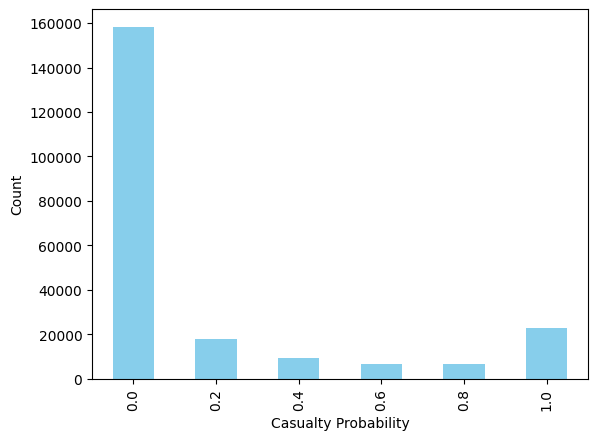

In [15]:
print(f"Percent of tweets possibly talking about {LABEL}: {round(len(df[df[LABEL] > 0.0]) / len(df), 2)}%")


counts = df['casualty'].round(2).value_counts().sort_index()
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Casualty Probability')
plt.ylabel('Count')
plt.show()

In [16]:
min_date = df.ts.min().date()
max_date = df.ts.max().date()
print(f"Batch of tweets about Ukraine's conflict uploaded from {min_date} to {max_date}")

Batch of tweets about Ukraine's conflict uploaded from 2022-02-22 to 2022-03-07


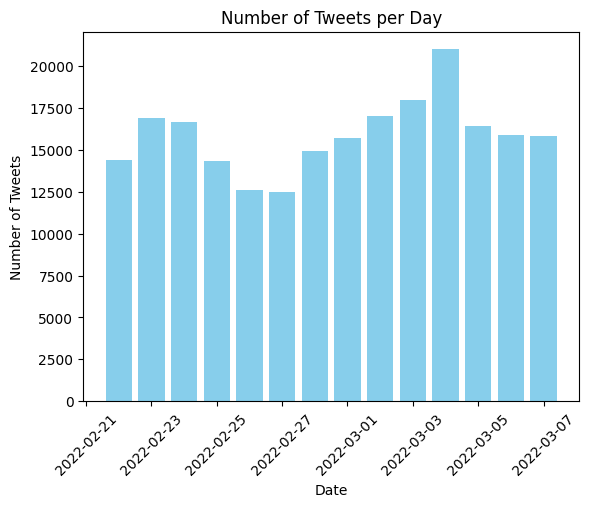

In [17]:
tweets_per_day = df["ts"].dt.date.value_counts().sort_index()
# Plotting the histogram
plt.bar(tweets_per_day.index, tweets_per_day.values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Day')
plt.xticks(rotation=45)
plt.show()

## Embedding tweets

In [18]:
# Returns the same df but with an additional column "embedding" of the (clean) tweet
def embed_df(df):

    embedded_tweets = EMBEDDING_MODEL.encode(df["text_clean"])

    df["embedding"] = embedded_tweets

    return df


# Returns embedded text
def embed_text(txt):

    return EMBEDDING_MODEL.encode(txt)

In [19]:
if EXECUTE_EMBEDDING:
  df = embed_df(df)

## Building the model

In [20]:
def create_model():

  model = tf.keras.Sequential([
      tf.keras.Input(shape=(EMBEDDING_DIMENSION,), dtype="float32"),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
  ])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics =  [ tf.keras.metrics.BinaryAccuracy() ])

  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10).
  # Get only the best model out of every epoch
  callback = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', save_best_only=True, mode='max', verbose=0, patience=10, filepath='prova.h5')

  return model, callback


model, _ = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                24640     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 batch_normalization_1 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

## Active Learning Methods

In [21]:
# Simple Greedy Algorithm
# Core Set: Farthest First Traversal
# Complexity: O(n*BUDGET)
def cs_farthest_first_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  points = df["embedding"].tolist()

  distances = euclidean_distances(points, points)

  while budget > 0:

    chosen = random.randint(0, len(df) - 1)

    curr = time.time()

    furthest = 0
    furthest_dist = 0

    # Searching for the element furthest away from the currently chosen one
    for i in range(len(df)):


      total_distance = distances[chosen, i]

      if furthest_dist < total_distance:
        # Avoiding elements already labelled
        if df.iloc[i]["embedding"] in list(labelled.keys()):
          continue
        furthest = i
        furthest_dist = total_distance


    labelled[df.iloc[furthest]["embedding"]] = classify(df.iloc[furthest][LABEL])

    budget -= 1

  del distances
  return labelled


In [22]:
# Core Set: Minimax
def cs_minimax_selection(df, labelled, budget, label_column):
  df = df.reset_index(drop=True)

  start = time.time()
  start_budget = budget

  points = df["embedding"].tolist()

  if len(labelled) == 0:
      labelled = {df.iloc[0]["embedding"]:df.iloc[0][LABEL]}

  distances = euclidean_distances(np.array(list(labelled.keys())), points)

  min_values = distances.min(axis=0)

  distances = euclidean_distances(points, points)


  while budget > 0:
    # Get argmax of minimum distances
    argmax = min_values.argmax()

    labelled[df.iloc[argmax]["embedding"]] = classify(df.iloc[argmax][LABEL])

    min_values = np.array([min(min_values[i], distances[argmax][i]) for i in range(len(min_values))])

    budget -= 1

  return labelled

In [23]:
# Good old random selection
def random_selection(curr, labelled:dict, budget:int, label_column:str):

  curr = curr.sample(budget)
  for i, label in zip(curr['embedding'], curr[label_column]):
    labelled[i] = classify(label)

  return labelled


In [24]:
al_methods = {"minimax":cs_minimax_selection,
              "farthest_first":cs_farthest_first_selection,
              "random":random_selection}

In [25]:
# Testing if Core Set Farthest First selection works
def check_label_position(df, labels, show_label=False):

  test = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=4).fit_transform(np.array(list(df["embedding"])))
  test = pd.DataFrame(test, columns = ["0_", "1_"])

  test["selected"] = [1 if i in labels.keys() else 0 for i in df["embedding"]]
  test[LABEL] = [i for i in df[LABEL]]
  test_labelled = test[test["selected"] == 1]

  plt.scatter(test["0_"], test["1_"], marker="x", c="black")
  if show_label:
    false_labels = test_labelled[test_labelled[LABEL] == 0]
    plt.scatter(false_labels["0_"], false_labels["1_"], marker="x", c="red")
    true_labels = test_labelled[test_labelled[LABEL] == 1]
    plt.scatter(true_labels["0_"], true_labels["1_"], marker="x", c="green")

  else:
    plt.scatter(test_labelled["0_"], test_labelled["1_"], marker="x", c="cyan")

  plt.show()


In [26]:
if CHECK_POSITION:
  curr = df[df.ts.dt.date == min_date]

  for method in al_methods.keys():
    labelled_elements = al_methods[method](curr, {}, BUDGET, LABEL)
    print(f"{method} selection")
    check_label_position(curr, labelled_elements, show_label=True)


In [27]:
def get_network_sets(x, y, next):

  # Splitting data into training, validation and test set
  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TRAIN_RATIO, random_state=SEED)
  x_test, y_test = next['embedding'], next[LABEL]

  # Changing format to correctly use in neural network
  x_train = np.array([np.array(val) for val in x_train])
  y_train = np.array([np.array(val) for val in y_train])
  x_test = np.array([np.array(val) for val in x_test])
  y_test = np.array([np.array(val) for val in y_test])
  x_val = np.array([np.array(val) for val in x_val])
  y_val = np.array([np.array(val) for val in y_val])

  x_train = tf.cast(x_train , dtype=tf.float32)
  y_train = tf.cast(y_train , dtype=tf.float32)
  x_test = tf.cast(x_train , dtype=tf.float32)
  y_test = tf.cast(y_train , dtype=tf.float32)
  x_val = tf.cast(x_train , dtype=tf.float32)
  y_val = tf.cast(y_train , dtype=tf.float32)

  return x_train, y_train, x_test, y_test, x_val, y_val

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1388/1388 [==============================] - ETA: 0s - loss: 0.2161 - binary_accuracy: 0.6782

1388/1388 [==============================] - 23s 10ms/step - loss: 0.2161 - binary_accuracy: 0.6782 - val_loss: 0.4033 - val_binary_accuracy: 0.7078
Epoch 2/20
1384/1388 [============================>.] - ETA: 0s - loss: 0.1970 - binary_accuracy: 0.7181

1388/1388 [==============================] - 17s 12ms/step - loss: 0.1971 - binary_accuracy: 0.7182 - val_loss: 0.3652 - val_binary_accuracy: 0.7285
Epoch 3/20
1385/1388 [============================>.] - ETA: 0s - loss: 0.1950 - binary_accuracy: 0.7166

1388/1388 [==============================] - 15s 11ms/step - loss: 0.1950 - binary_accuracy: 0.7167 - val_loss: 0.3635 - val_binary_accuracy: 0.7251
Epoch 4/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1903 - binary_accuracy: 0.7250

1388/1388 [==============================] - 14s 10ms/step - loss: 0.1903 - binary_accuracy: 0.7250 - val_loss: 0.3600 - val_binary_accuracy: 0.7271
Epoch 5/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1887 - binary_accuracy: 0.7241

1388/1388 [==============================] - 15s 11ms/step - loss: 0.1887 - binary_accuracy: 0.7242 - val_loss: 0.3438 - val_binary_accuracy: 0.7372
Epoch 6/20
1384/1388 [============================>.] - ETA: 0s - loss: 0.1862 - binary_accuracy: 0.7269

1388/1388 [==============================] - 14s 10ms/step - loss: 0.1861 - binary_accuracy: 0.7270 - val_loss: 0.3306 - val_binary_accuracy: 0.7460
Epoch 7/20
1384/1388 [============================>.] - ETA: 0s - loss: 0.1836 - binary_accuracy: 0.7295

1388/1388 [==============================] - 13s 10ms/step - loss: 0.1836 - binary_accuracy: 0.7295 - val_loss: 0.3241 - val_binary_accuracy: 0.7436
Epoch 8/20
1386/1388 [============================>.] - ETA: 0s - loss: 0.1823 - binary_accuracy: 0.7292

1388/1388 [==============================] - 10s 7ms/step - loss: 0.1823 - binary_accuracy: 0.7291 - val_loss: 0.3675 - val_binary_accuracy: 0.7172
Epoch 9/20
1385/1388 [============================>.] - ETA: 0s - loss: 0.1811 - binary_accuracy: 0.7295

1388/1388 [==============================] - 11s 8ms/step - loss: 0.1811 - binary_accuracy: 0.7296 - val_loss: 0.3038 - val_binary_accuracy: 0.7575
Epoch 10/20
1382/1388 [============================>.] - ETA: 0s - loss: 0.1799 - binary_accuracy: 0.7296

1388/1388 [==============================] - 13s 10ms/step - loss: 0.1798 - binary_accuracy: 0.7296 - val_loss: 0.3025 - val_binary_accuracy: 0.7576
Epoch 11/20
1388/1388 [==============================] - ETA: 0s - loss: 0.1791 - binary_accuracy: 0.7318

1388/1388 [==============================] - 11s 8ms/step - loss: 0.1791 - binary_accuracy: 0.7318 - val_loss: 0.3150 - val_binary_accuracy: 0.7455
Epoch 12/20
1384/1388 [============================>.] - ETA: 0s - loss: 0.1765 - binary_accuracy: 0.7318

1388/1388 [==============================] - 14s 10ms/step - loss: 0.1765 - binary_accuracy: 0.7319 - val_loss: 0.3374 - val_binary_accuracy: 0.7306
Epoch 13/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1751 - binary_accuracy: 0.7321

1388/1388 [==============================] - 16s 11ms/step - loss: 0.1750 - binary_accuracy: 0.7321 - val_loss: 0.2862 - val_binary_accuracy: 0.7623
Epoch 14/20
1381/1388 [============================>.] - ETA: 0s - loss: 0.1739 - binary_accuracy: 0.7344

1388/1388 [==============================] - 13s 10ms/step - loss: 0.1741 - binary_accuracy: 0.7344 - val_loss: 0.2957 - val_binary_accuracy: 0.7563
Epoch 15/20
1381/1388 [============================>.] - ETA: 0s - loss: 0.1731 - binary_accuracy: 0.7350

1388/1388 [==============================] - 11s 8ms/step - loss: 0.1732 - binary_accuracy: 0.7350 - val_loss: 0.3324 - val_binary_accuracy: 0.7308
Epoch 16/20
1385/1388 [============================>.] - ETA: 0s - loss: 0.1723 - binary_accuracy: 0.7342

1388/1388 [==============================] - 15s 11ms/step - loss: 0.1724 - binary_accuracy: 0.7341 - val_loss: 0.3351 - val_binary_accuracy: 0.7314
Epoch 17/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1720 - binary_accuracy: 0.7356

1388/1388 [==============================] - 11s 8ms/step - loss: 0.1721 - binary_accuracy: 0.7356 - val_loss: 0.3068 - val_binary_accuracy: 0.7468
Epoch 18/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1699 - binary_accuracy: 0.7360

1388/1388 [==============================] - 11s 8ms/step - loss: 0.1699 - binary_accuracy: 0.7360 - val_loss: 0.3049 - val_binary_accuracy: 0.7486
Epoch 19/20
1383/1388 [============================>.] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.7402

1388/1388 [==============================] - 12s 9ms/step - loss: 0.1687 - binary_accuracy: 0.7402 - val_loss: 0.3149 - val_binary_accuracy: 0.7418
Epoch 20/20
1387/1388 [============================>.] - ETA: 0s - loss: 0.1681 - binary_accuracy: 0.7388

1388/1388 [==============================] - 3s 2ms/step - loss: 0.3150 - binary_accuracy: 0.7460
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
1388/1388 [==============================] - 4s 3ms/step - loss: 0.3150 - binary_accuracy: 0.7460
Test Accuracy
1388/1388 [==============================] - 4s 3ms/step - loss: 0.3150 - binary_accuracy: 0.7460


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


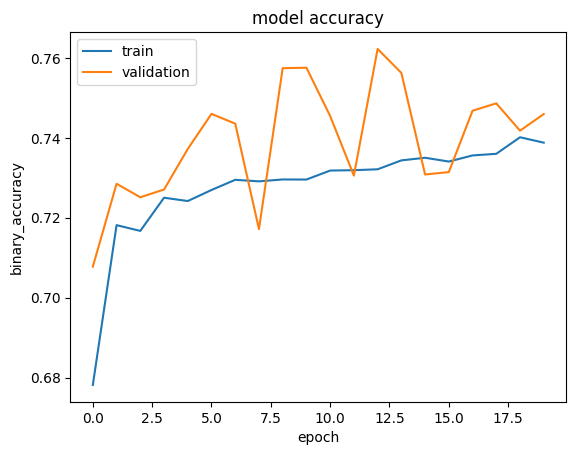

In [28]:
if BEST_SCENARIO:

  curr = df[df.ts.dt.date != max_date]
  next = df[df.ts.dt.date == max_date]

  x, y = df["embedding"], df[LABEL]

  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, df)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)
  print(history.history.keys())

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)
  history.history['binary_accuracy']

  model.save('best_result.h5')

  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title(f'model accuracy')
  plt.ylabel('binary_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/7 [===>..........................] - ETA: 14s - loss: 0.6901 - binary_accuracy: 0.5938

7/7 [==============================] - 3s 66ms/step - loss: 0.6034 - binary_accuracy: 0.5550 - val_loss: 0.6697 - val_binary_accuracy: 0.8700
Epoch 2/20
1/7 [===>..........................] - ETA: 0s - loss: 0.7894 - binary_accuracy: 0.5938

7/7 [==============================] - 0s 24ms/step - loss: 0.5658 - binary_accuracy: 0.5900 - val_loss: 0.6489 - val_binary_accuracy: 0.9500
Epoch 3/20
1/7 [===>..........................] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.5938

7/7 [==============================] - 0s 24ms/step - loss: 0.4326 - binary_accuracy: 0.6600 - val_loss: 0.6288 - val_binary_accuracy: 0.9650
Epoch 4/20
1/7 [===>..........................] - ETA: 0s - loss: 0.4742 - binary_accuracy: 0.7188

7/7 [==============================] - 0s 23ms/step - loss: 0.4168 - binary_accuracy: 0.6350 - val_loss: 0.6082 - val_binary_accuracy: 0.9500
Epoch 5/20
1/7 [===>..........................] - ETA: 0s - loss: 0.4155 - binary_accuracy: 0.5938

7/7 [==============================] - 0s 19ms/step - loss: 0.4590 - binary_accuracy: 0.6650 - val_loss: 0.5865 - val_binary_accuracy: 0.9500
Epoch 6/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3430 - binary_accuracy: 0.7500

7/7 [==============================] - 0s 24ms/step - loss: 0.3712 - binary_accuracy: 0.7000 - val_loss: 0.5653 - val_binary_accuracy: 0.9450
Epoch 7/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3003 - binary_accuracy: 0.7812

7/7 [==============================] - 0s 13ms/step - loss: 0.3819 - binary_accuracy: 0.6850 - val_loss: 0.5485 - val_binary_accuracy: 0.9450
Epoch 8/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3665 - binary_accuracy: 0.7188

7/7 [==============================] - 0s 13ms/step - loss: 0.3652 - binary_accuracy: 0.7100 - val_loss: 0.5314 - val_binary_accuracy: 0.9450
Epoch 9/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3333 - binary_accuracy: 0.6250

7/7 [==============================] - 0s 13ms/step - loss: 0.3471 - binary_accuracy: 0.6950 - val_loss: 0.5150 - val_binary_accuracy: 0.9450
Epoch 10/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3369 - binary_accuracy: 0.7500

7/7 [==============================] - 0s 12ms/step - loss: 0.3452 - binary_accuracy: 0.7250 - val_loss: 0.5004 - val_binary_accuracy: 0.9450
Epoch 11/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3408 - binary_accuracy: 0.7188

7/7 [==============================] - 0s 14ms/step - loss: 0.2962 - binary_accuracy: 0.7700 - val_loss: 0.4879 - val_binary_accuracy: 0.9450
Epoch 12/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3026 - binary_accuracy: 0.6875

7/7 [==============================] - 0s 13ms/step - loss: 0.3164 - binary_accuracy: 0.7300 - val_loss: 0.4757 - val_binary_accuracy: 0.9450
Epoch 13/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3226 - binary_accuracy: 0.8125

7/7 [==============================] - 0s 12ms/step - loss: 0.3125 - binary_accuracy: 0.7750 - val_loss: 0.4632 - val_binary_accuracy: 0.9450
Epoch 14/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3520 - binary_accuracy: 0.6562

7/7 [==============================] - 0s 13ms/step - loss: 0.3102 - binary_accuracy: 0.7400 - val_loss: 0.4516 - val_binary_accuracy: 0.9450
Epoch 15/20
1/7 [===>..........................] - ETA: 0s - loss: 0.4356 - binary_accuracy: 0.8125

7/7 [==============================] - 0s 12ms/step - loss: 0.3159 - binary_accuracy: 0.7700 - val_loss: 0.4405 - val_binary_accuracy: 0.9450
Epoch 16/20
1/7 [===>..........................] - ETA: 0s - loss: 0.4655 - binary_accuracy: 0.8125

7/7 [==============================] - 0s 13ms/step - loss: 0.3425 - binary_accuracy: 0.7650 - val_loss: 0.4295 - val_binary_accuracy: 0.9450
Epoch 17/20
1/7 [===>..........................] - ETA: 0s - loss: 0.2672 - binary_accuracy: 0.7500

7/7 [==============================] - 0s 13ms/step - loss: 0.2799 - binary_accuracy: 0.8150 - val_loss: 0.4177 - val_binary_accuracy: 0.9450
Epoch 18/20
1/7 [===>..........................] - ETA: 0s - loss: 0.2237 - binary_accuracy: 0.8750

7/7 [==============================] - 0s 14ms/step - loss: 0.2783 - binary_accuracy: 0.8250 - val_loss: 0.4083 - val_binary_accuracy: 0.9450
Epoch 19/20
1/7 [===>..........................] - ETA: 0s - loss: 0.3813 - binary_accuracy: 0.6875

7/7 [==============================] - 0s 12ms/step - loss: 0.2661 - binary_accuracy: 0.8250 - val_loss: 0.3981 - val_binary_accuracy: 0.9450
Epoch 20/20
1/7 [===>..........................] - ETA: 0s - loss: 0.2529 - binary_accuracy: 0.8438

7/7 [==============================] - 0s 3ms/step - loss: 0.3895 - binary_accuracy: 0.9450
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.3895 - binary_accuracy: 0.9450
Test Accuracy
7/7 [==============================] - 0s 3ms/step - loss: 0.3895 - binary_accuracy: 0.9450


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


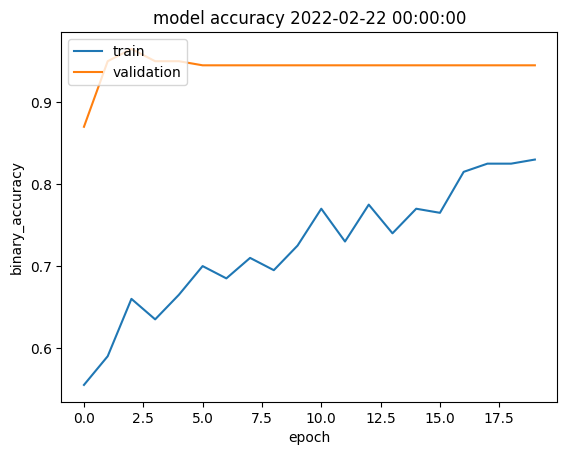

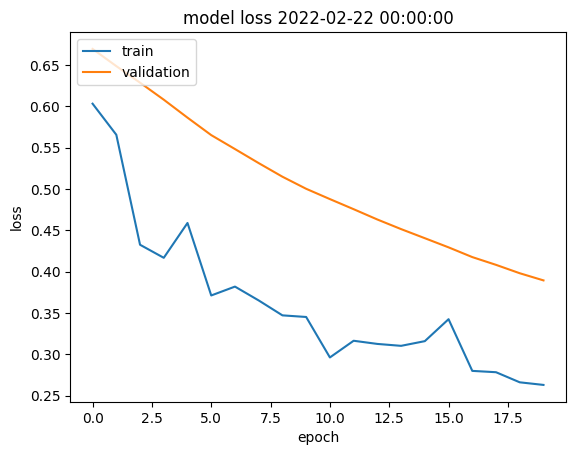

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 8/13 [=================>............] - ETA: 0s - loss: 0.6699 - binary_accuracy: 0.4336 

13/13 [==============================] - 3s 37ms/step - loss: 0.6635 - binary_accuracy: 0.4275 - val_loss: 0.7065 - val_binary_accuracy: 0.1475
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.5473 - binary_accuracy: 0.4975

13/13 [==============================] - 0s 17ms/step - loss: 0.5473 - binary_accuracy: 0.4975 - val_loss: 0.7189 - val_binary_accuracy: 0.0800
Epoch 3/20
 7/13 [===============>..............] - ETA: 0s - loss: 0.4973 - binary_accuracy: 0.4911

13/13 [==============================] - 0s 14ms/step - loss: 0.5290 - binary_accuracy: 0.5000 - val_loss: 0.7285 - val_binary_accuracy: 0.0725
Epoch 4/20
11/13 [========================>.....] - ETA: 0s - loss: 0.5100 - binary_accuracy: 0.5199

13/13 [==============================] - 0s 11ms/step - loss: 0.5112 - binary_accuracy: 0.5150 - val_loss: 0.7321 - val_binary_accuracy: 0.0775
Epoch 5/20
11/13 [========================>.....] - ETA: 0s - loss: 0.4912 - binary_accuracy: 0.5341

13/13 [==============================] - 0s 13ms/step - loss: 0.4919 - binary_accuracy: 0.5375 - val_loss: 0.7324 - val_binary_accuracy: 0.0875
Epoch 6/20
11/13 [========================>.....] - ETA: 0s - loss: 0.4803 - binary_accuracy: 0.5426

13/13 [==============================] - 0s 10ms/step - loss: 0.4713 - binary_accuracy: 0.5450 - val_loss: 0.7271 - val_binary_accuracy: 0.1250
Epoch 7/20
12/13 [==========================>...] - ETA: 0s - loss: 0.4636 - binary_accuracy: 0.5964

13/13 [==============================] - 0s 12ms/step - loss: 0.4611 - binary_accuracy: 0.6000 - val_loss: 0.7166 - val_binary_accuracy: 0.1925
Epoch 8/20
11/13 [========================>.....] - ETA: 0s - loss: 0.4541 - binary_accuracy: 0.6250

13/13 [==============================] - 0s 10ms/step - loss: 0.4453 - binary_accuracy: 0.6050 - val_loss: 0.7009 - val_binary_accuracy: 0.3900
Epoch 9/20
10/13 [======================>.......] - ETA: 0s - loss: 0.4210 - binary_accuracy: 0.6219

13/13 [==============================] - 0s 13ms/step - loss: 0.4241 - binary_accuracy: 0.6350 - val_loss: 0.6803 - val_binary_accuracy: 0.6175
Epoch 10/20
10/13 [======================>.......] - ETA: 0s - loss: 0.4304 - binary_accuracy: 0.6187

13/13 [==============================] - 0s 13ms/step - loss: 0.4321 - binary_accuracy: 0.6275 - val_loss: 0.6597 - val_binary_accuracy: 0.7800
Epoch 11/20
10/13 [======================>.......] - ETA: 0s - loss: 0.3739 - binary_accuracy: 0.6781

13/13 [==============================] - 0s 10ms/step - loss: 0.3816 - binary_accuracy: 0.6800 - val_loss: 0.6385 - val_binary_accuracy: 0.8875
Epoch 12/20
11/13 [========================>.....] - ETA: 0s - loss: 0.3884 - binary_accuracy: 0.6847

13/13 [==============================] - 0s 12ms/step - loss: 0.3941 - binary_accuracy: 0.6925 - val_loss: 0.6135 - val_binary_accuracy: 0.9525
Epoch 13/20
11/13 [========================>.....] - ETA: 0s - loss: 0.3613 - binary_accuracy: 0.7216

13/13 [==============================] - 0s 9ms/step - loss: 0.3564 - binary_accuracy: 0.7100 - val_loss: 0.5865 - val_binary_accuracy: 0.9775
Epoch 14/20
10/13 [======================>.......] - ETA: 0s - loss: 0.3420 - binary_accuracy: 0.7437

13/13 [==============================] - 0s 10ms/step - loss: 0.3435 - binary_accuracy: 0.7500 - val_loss: 0.5629 - val_binary_accuracy: 0.9950
Epoch 15/20
11/13 [========================>.....] - ETA: 0s - loss: 0.3375 - binary_accuracy: 0.7614

13/13 [==============================] - 0s 10ms/step - loss: 0.3408 - binary_accuracy: 0.7550 - val_loss: 0.5362 - val_binary_accuracy: 0.9975
Epoch 16/20
10/13 [======================>.......] - ETA: 0s - loss: 0.2994 - binary_accuracy: 0.7969

13/13 [==============================] - 0s 13ms/step - loss: 0.3023 - binary_accuracy: 0.8100 - val_loss: 0.5122 - val_binary_accuracy: 1.0000
Epoch 17/20
10/13 [======================>.......] - ETA: 0s - loss: 0.2940 - binary_accuracy: 0.7937

13/13 [==============================] - 0s 10ms/step - loss: 0.2945 - binary_accuracy: 0.7925 - val_loss: 0.4880 - val_binary_accuracy: 1.0000
Epoch 18/20
11/13 [========================>.....] - ETA: 0s - loss: 0.2929 - binary_accuracy: 0.8068

13/13 [==============================] - 0s 11ms/step - loss: 0.2905 - binary_accuracy: 0.8100 - val_loss: 0.4697 - val_binary_accuracy: 1.0000
Epoch 19/20
10/13 [======================>.......] - ETA: 0s - loss: 0.2856 - binary_accuracy: 0.8156

13/13 [==============================] - 0s 10ms/step - loss: 0.2823 - binary_accuracy: 0.8200 - val_loss: 0.4448 - val_binary_accuracy: 1.0000
Epoch 20/20
11/13 [========================>.....] - ETA: 0s - loss: 0.2475 - binary_accuracy: 0.8381

13/13 [==============================] - 0s 3ms/step - loss: 0.4217 - binary_accuracy: 1.0000
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
13/13 [==============================] - 0s 3ms/step - loss: 0.4217 - binary_accuracy: 1.0000
Test Accuracy
13/13 [==============================] - 0s 3ms/step - loss: 0.4217 - binary_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


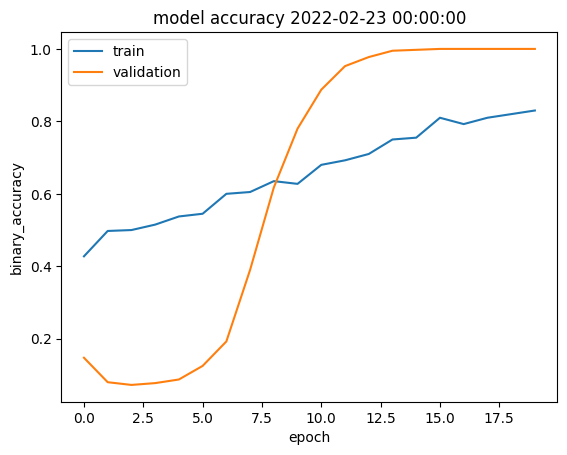

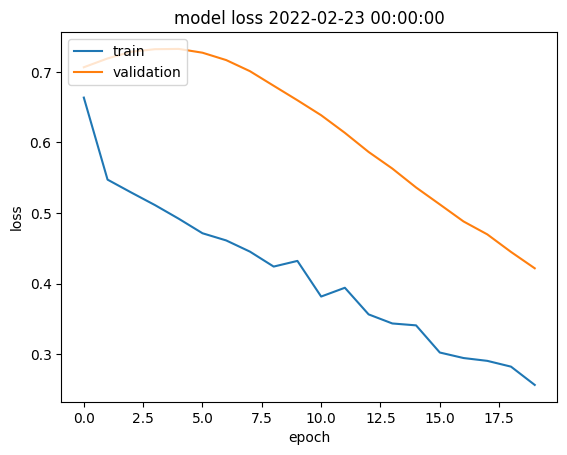

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/19 [========================>.....] - ETA: 0s - loss: 0.8045 - binary_accuracy: 0.5566

19/19 [==============================] - 2s 23ms/step - loss: 0.7974 - binary_accuracy: 0.5483 - val_loss: 0.6261 - val_binary_accuracy: 0.9117
Epoch 2/20
18/19 [===========================>..] - ETA: 0s - loss: 0.5757 - binary_accuracy: 0.6198

19/19 [==============================] - 0s 12ms/step - loss: 0.5710 - binary_accuracy: 0.6183 - val_loss: 0.5364 - val_binary_accuracy: 0.9033
Epoch 3/20
14/19 [=====================>........] - ETA: 0s - loss: 0.5180 - binary_accuracy: 0.6406

19/19 [==============================] - 0s 11ms/step - loss: 0.4975 - binary_accuracy: 0.6467 - val_loss: 0.4652 - val_binary_accuracy: 0.9033
Epoch 4/20
17/19 [=========================>....] - ETA: 0s - loss: 0.4597 - binary_accuracy: 0.6875

19/19 [==============================] - 0s 10ms/step - loss: 0.4533 - binary_accuracy: 0.6833 - val_loss: 0.4094 - val_binary_accuracy: 0.9033
Epoch 5/20
17/19 [=========================>....] - ETA: 0s - loss: 0.4085 - binary_accuracy: 0.7169

19/19 [==============================] - 0s 11ms/step - loss: 0.4190 - binary_accuracy: 0.7133 - val_loss: 0.3679 - val_binary_accuracy: 0.9033
Epoch 6/20
17/19 [=========================>....] - ETA: 0s - loss: 0.3807 - binary_accuracy: 0.7610

19/19 [==============================] - 0s 11ms/step - loss: 0.3822 - binary_accuracy: 0.7533 - val_loss: 0.3392 - val_binary_accuracy: 0.9033
Epoch 7/20
18/19 [===========================>..] - ETA: 0s - loss: 0.3443 - binary_accuracy: 0.7622

19/19 [==============================] - 0s 11ms/step - loss: 0.3470 - binary_accuracy: 0.7683 - val_loss: 0.3171 - val_binary_accuracy: 0.9033
Epoch 8/20
18/19 [===========================>..] - ETA: 0s - loss: 0.4015 - binary_accuracy: 0.7656

19/19 [==============================] - 0s 11ms/step - loss: 0.3990 - binary_accuracy: 0.7717 - val_loss: 0.3005 - val_binary_accuracy: 0.9033
Epoch 9/20
18/19 [===========================>..] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8264

19/19 [==============================] - 0s 10ms/step - loss: 0.3092 - binary_accuracy: 0.8217 - val_loss: 0.2864 - val_binary_accuracy: 0.9033
Epoch 10/20
18/19 [===========================>..] - ETA: 0s - loss: 0.3397 - binary_accuracy: 0.8194

19/19 [==============================] - 0s 10ms/step - loss: 0.3402 - binary_accuracy: 0.8167 - val_loss: 0.2717 - val_binary_accuracy: 0.9033
Epoch 11/20
19/19 [==============================] - ETA: 0s - loss: 0.2723 - binary_accuracy: 0.8200

19/19 [==============================] - 0s 10ms/step - loss: 0.2723 - binary_accuracy: 0.8200 - val_loss: 0.2593 - val_binary_accuracy: 0.9033
Epoch 12/20
17/19 [=========================>....] - ETA: 0s - loss: 0.2585 - binary_accuracy: 0.8529

19/19 [==============================] - 0s 12ms/step - loss: 0.2522 - binary_accuracy: 0.8567 - val_loss: 0.2485 - val_binary_accuracy: 0.9033
Epoch 13/20
18/19 [===========================>..] - ETA: 0s - loss: 0.2578 - binary_accuracy: 0.8420

19/19 [==============================] - 0s 10ms/step - loss: 0.2545 - binary_accuracy: 0.8433 - val_loss: 0.2380 - val_binary_accuracy: 0.9033
Epoch 14/20
18/19 [===========================>..] - ETA: 0s - loss: 0.2397 - binary_accuracy: 0.8715

19/19 [==============================] - 0s 11ms/step - loss: 0.2406 - binary_accuracy: 0.8750 - val_loss: 0.2306 - val_binary_accuracy: 0.9033
Epoch 15/20
18/19 [===========================>..] - ETA: 0s - loss: 0.2134 - binary_accuracy: 0.8872

19/19 [==============================] - 0s 11ms/step - loss: 0.2128 - binary_accuracy: 0.8867 - val_loss: 0.2207 - val_binary_accuracy: 0.9033
Epoch 16/20
17/19 [=========================>....] - ETA: 0s - loss: 0.1948 - binary_accuracy: 0.8971

19/19 [==============================] - 0s 12ms/step - loss: 0.1945 - binary_accuracy: 0.8950 - val_loss: 0.2107 - val_binary_accuracy: 0.9033
Epoch 17/20
17/19 [=========================>....] - ETA: 0s - loss: 0.1949 - binary_accuracy: 0.8971

19/19 [==============================] - 0s 11ms/step - loss: 0.1953 - binary_accuracy: 0.9000 - val_loss: 0.1994 - val_binary_accuracy: 0.9033
Epoch 18/20
17/19 [=========================>....] - ETA: 0s - loss: 0.1793 - binary_accuracy: 0.9210

19/19 [==============================] - 0s 11ms/step - loss: 0.1909 - binary_accuracy: 0.9200 - val_loss: 0.1877 - val_binary_accuracy: 0.9033
Epoch 19/20
18/19 [===========================>..] - ETA: 0s - loss: 0.1774 - binary_accuracy: 0.9201

19/19 [==============================] - 0s 11ms/step - loss: 0.1745 - binary_accuracy: 0.9200 - val_loss: 0.1749 - val_binary_accuracy: 0.9067
Epoch 20/20
16/19 [========================>.....] - ETA: 0s - loss: 0.1612 - binary_accuracy: 0.9297

19/19 [==============================] - 0s 3ms/step - loss: 0.1595 - binary_accuracy: 0.9133
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
19/19 [==============================] - 0s 3ms/step - loss: 0.1595 - binary_accuracy: 0.9133
Test Accuracy
19/19 [==============================] - 0s 3ms/step - loss: 0.1595 - binary_accuracy: 0.9133


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


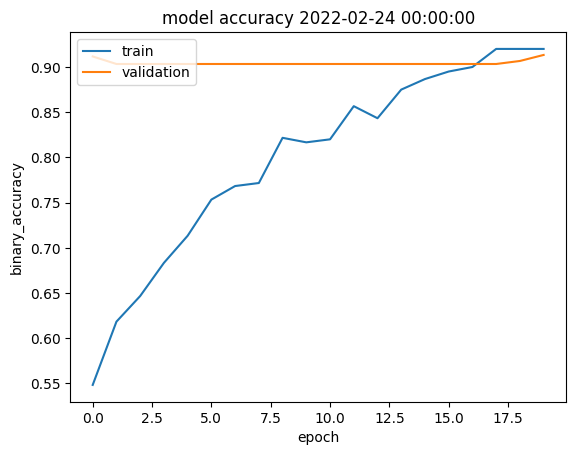

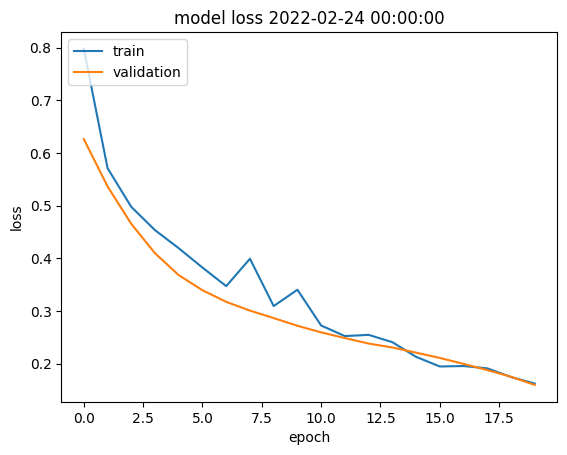

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/25 [===========================>..] - ETA: 0s - loss: 0.7772 - binary_accuracy: 0.4727

25/25 [==============================] - 3s 25ms/step - loss: 0.7836 - binary_accuracy: 0.4712 - val_loss: 0.6861 - val_binary_accuracy: 0.6862
Epoch 2/20
24/25 [===========================>..] - ETA: 0s - loss: 0.6270 - binary_accuracy: 0.5156

25/25 [==============================] - 0s 12ms/step - loss: 0.6233 - binary_accuracy: 0.5163 - val_loss: 0.6640 - val_binary_accuracy: 0.8938
Epoch 3/20
18/25 [====================>.........] - ETA: 0s - loss: 0.5997 - binary_accuracy: 0.5260

25/25 [==============================] - 0s 10ms/step - loss: 0.5875 - binary_accuracy: 0.5362 - val_loss: 0.6418 - val_binary_accuracy: 0.9187
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.5342 - binary_accuracy: 0.6000

25/25 [==============================] - 0s 8ms/step - loss: 0.5342 - binary_accuracy: 0.6000 - val_loss: 0.6123 - val_binary_accuracy: 0.9175
Epoch 5/20
14/25 [===============>..............] - ETA: 0s - loss: 0.5104 - binary_accuracy: 0.6027

25/25 [==============================] - 0s 7ms/step - loss: 0.5113 - binary_accuracy: 0.5975 - val_loss: 0.5742 - val_binary_accuracy: 0.9112
Epoch 6/20
14/25 [===============>..............] - ETA: 0s - loss: 0.4539 - binary_accuracy: 0.6629

25/25 [==============================] - 0s 8ms/step - loss: 0.4558 - binary_accuracy: 0.6775 - val_loss: 0.5317 - val_binary_accuracy: 0.8988
Epoch 7/20
24/25 [===========================>..] - ETA: 0s - loss: 0.4088 - binary_accuracy: 0.6979

25/25 [==============================] - 0s 8ms/step - loss: 0.4077 - binary_accuracy: 0.6975 - val_loss: 0.4945 - val_binary_accuracy: 0.8963
Epoch 8/20
13/25 [==============>...............] - ETA: 0s - loss: 0.4102 - binary_accuracy: 0.7236

25/25 [==============================] - 0s 7ms/step - loss: 0.3998 - binary_accuracy: 0.7487 - val_loss: 0.4662 - val_binary_accuracy: 0.8950
Epoch 9/20
24/25 [===========================>..] - ETA: 0s - loss: 0.3556 - binary_accuracy: 0.7734

25/25 [==============================] - 0s 8ms/step - loss: 0.3536 - binary_accuracy: 0.7725 - val_loss: 0.4309 - val_binary_accuracy: 0.8963
Epoch 10/20
14/25 [===============>..............] - ETA: 0s - loss: 0.3217 - binary_accuracy: 0.8103

25/25 [==============================] - 0s 7ms/step - loss: 0.3376 - binary_accuracy: 0.8012 - val_loss: 0.3980 - val_binary_accuracy: 0.8963
Epoch 11/20
24/25 [===========================>..] - ETA: 0s - loss: 0.3215 - binary_accuracy: 0.7995

25/25 [==============================] - 0s 8ms/step - loss: 0.3184 - binary_accuracy: 0.8037 - val_loss: 0.3753 - val_binary_accuracy: 0.8975
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.3016 - binary_accuracy: 0.8438

25/25 [==============================] - 0s 7ms/step - loss: 0.3016 - binary_accuracy: 0.8438 - val_loss: 0.3490 - val_binary_accuracy: 0.8963
Epoch 13/20
23/25 [==========================>...] - ETA: 0s - loss: 0.2678 - binary_accuracy: 0.8668

25/25 [==============================] - 0s 8ms/step - loss: 0.2675 - binary_accuracy: 0.8700 - val_loss: 0.3172 - val_binary_accuracy: 0.8975
Epoch 14/20
21/25 [========================>.....] - ETA: 0s - loss: 0.2333 - binary_accuracy: 0.8899

25/25 [==============================] - 0s 8ms/step - loss: 0.2328 - binary_accuracy: 0.8875 - val_loss: 0.2914 - val_binary_accuracy: 0.9000
Epoch 15/20
22/25 [=========================>....] - ETA: 0s - loss: 0.2179 - binary_accuracy: 0.9105

25/25 [==============================] - 0s 8ms/step - loss: 0.2197 - binary_accuracy: 0.9125 - val_loss: 0.2662 - val_binary_accuracy: 0.9112
Epoch 16/20
23/25 [==========================>...] - ETA: 0s - loss: 0.1939 - binary_accuracy: 0.9198

25/25 [==============================] - 0s 8ms/step - loss: 0.1916 - binary_accuracy: 0.9212 - val_loss: 0.2397 - val_binary_accuracy: 0.9375
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.1728 - binary_accuracy: 0.9362

25/25 [==============================] - 0s 8ms/step - loss: 0.1728 - binary_accuracy: 0.9362 - val_loss: 0.2144 - val_binary_accuracy: 0.9688
Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.1913 - binary_accuracy: 0.9300

25/25 [==============================] - 0s 7ms/step - loss: 0.1913 - binary_accuracy: 0.9300 - val_loss: 0.1905 - val_binary_accuracy: 0.9650
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.1568 - binary_accuracy: 0.9513

25/25 [==============================] - 0s 7ms/step - loss: 0.1568 - binary_accuracy: 0.9513 - val_loss: 0.1671 - val_binary_accuracy: 0.9850
Epoch 20/20
24/25 [===========================>..] - ETA: 0s - loss: 0.1556 - binary_accuracy: 0.9557

25/25 [==============================] - 0s 3ms/step - loss: 0.1439 - binary_accuracy: 0.9937
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
25/25 [==============================] - 0s 3ms/step - loss: 0.1439 - binary_accuracy: 0.9937
Test Accuracy
25/25 [==============================] - 0s 3ms/step - loss: 0.1439 - binary_accuracy: 0.9937


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


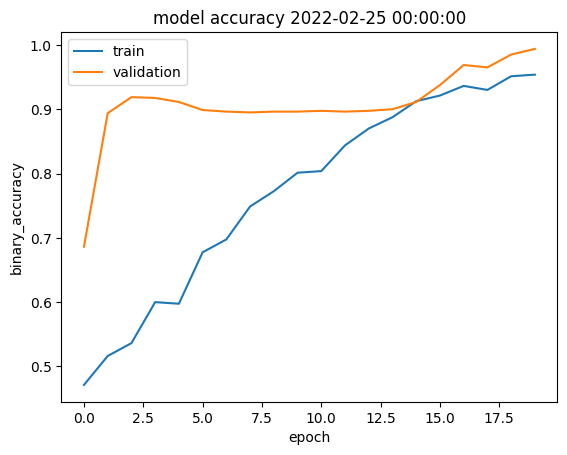

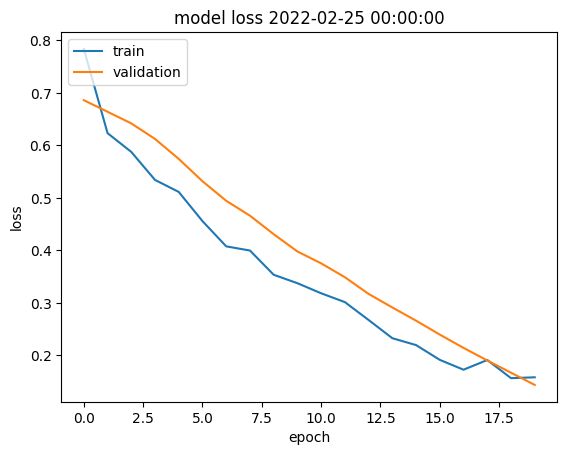

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/32 [===========================>..] - ETA: 0s - loss: 0.8147 - binary_accuracy: 0.5552

32/32 [==============================] - 2s 16ms/step - loss: 0.8258 - binary_accuracy: 0.5520 - val_loss: 0.6324 - val_binary_accuracy: 0.9070
Epoch 2/20
25/32 [======================>.......] - ETA: 0s - loss: 0.5997 - binary_accuracy: 0.6200

32/32 [==============================] - 0s 9ms/step - loss: 0.6153 - binary_accuracy: 0.6250 - val_loss: 0.5847 - val_binary_accuracy: 0.8990
Epoch 3/20
30/32 [===========================>..] - ETA: 0s - loss: 0.5260 - binary_accuracy: 0.6344

32/32 [==============================] - 0s 11ms/step - loss: 0.5243 - binary_accuracy: 0.6340 - val_loss: 0.5333 - val_binary_accuracy: 0.8910
Epoch 4/20
30/32 [===========================>..] - ETA: 0s - loss: 0.4528 - binary_accuracy: 0.6917

32/32 [==============================] - 0s 9ms/step - loss: 0.4497 - binary_accuracy: 0.6900 - val_loss: 0.4841 - val_binary_accuracy: 0.8840
Epoch 5/20
28/32 [=========================>....] - ETA: 0s - loss: 0.4110 - binary_accuracy: 0.7087

32/32 [==============================] - 0s 9ms/step - loss: 0.4040 - binary_accuracy: 0.7200 - val_loss: 0.4441 - val_binary_accuracy: 0.8820
Epoch 6/20
25/32 [======================>.......] - ETA: 0s - loss: 0.3927 - binary_accuracy: 0.7450

32/32 [==============================] - 0s 9ms/step - loss: 0.4025 - binary_accuracy: 0.7470 - val_loss: 0.4033 - val_binary_accuracy: 0.8820
Epoch 7/20
30/32 [===========================>..] - ETA: 0s - loss: 0.3909 - binary_accuracy: 0.7396

32/32 [==============================] - 0s 11ms/step - loss: 0.3887 - binary_accuracy: 0.7440 - val_loss: 0.3744 - val_binary_accuracy: 0.8850
Epoch 8/20
26/32 [=======================>......] - ETA: 0s - loss: 0.3682 - binary_accuracy: 0.7740

32/32 [==============================] - 0s 12ms/step - loss: 0.3636 - binary_accuracy: 0.7780 - val_loss: 0.3442 - val_binary_accuracy: 0.8860
Epoch 9/20
27/32 [========================>.....] - ETA: 0s - loss: 0.3213 - binary_accuracy: 0.7986

32/32 [==============================] - 0s 13ms/step - loss: 0.3195 - binary_accuracy: 0.8000 - val_loss: 0.3151 - val_binary_accuracy: 0.8890
Epoch 10/20
31/32 [============================>.] - ETA: 0s - loss: 0.3124 - binary_accuracy: 0.8317

32/32 [==============================] - 0s 12ms/step - loss: 0.3128 - binary_accuracy: 0.8300 - val_loss: 0.2878 - val_binary_accuracy: 0.8930
Epoch 11/20
28/32 [=========================>....] - ETA: 0s - loss: 0.2649 - binary_accuracy: 0.8493

32/32 [==============================] - 0s 15ms/step - loss: 0.2641 - binary_accuracy: 0.8470 - val_loss: 0.2599 - val_binary_accuracy: 0.9090
Epoch 12/20
31/32 [============================>.] - ETA: 0s - loss: 0.2592 - binary_accuracy: 0.8710

32/32 [==============================] - 0s 13ms/step - loss: 0.2611 - binary_accuracy: 0.8690 - val_loss: 0.2324 - val_binary_accuracy: 0.9230
Epoch 13/20
27/32 [========================>.....] - ETA: 0s - loss: 0.2215 - binary_accuracy: 0.8970

32/32 [==============================] - 0s 12ms/step - loss: 0.2164 - binary_accuracy: 0.9020 - val_loss: 0.2094 - val_binary_accuracy: 0.9240
Epoch 14/20
31/32 [============================>.] - ETA: 0s - loss: 0.2200 - binary_accuracy: 0.9012

32/32 [==============================] - 0s 15ms/step - loss: 0.2199 - binary_accuracy: 0.9010 - val_loss: 0.1809 - val_binary_accuracy: 0.9500
Epoch 15/20
26/32 [=======================>......] - ETA: 0s - loss: 0.1933 - binary_accuracy: 0.9195

32/32 [==============================] - 0s 13ms/step - loss: 0.1972 - binary_accuracy: 0.9180 - val_loss: 0.1546 - val_binary_accuracy: 0.9670
Epoch 16/20
24/32 [=====================>........] - ETA: 0s - loss: 0.2022 - binary_accuracy: 0.9128

32/32 [==============================] - 0s 10ms/step - loss: 0.1998 - binary_accuracy: 0.9100 - val_loss: 0.1297 - val_binary_accuracy: 0.9850
Epoch 17/20
29/32 [==========================>...] - ETA: 0s - loss: 0.1757 - binary_accuracy: 0.9159

32/32 [==============================] - 0s 9ms/step - loss: 0.1783 - binary_accuracy: 0.9210 - val_loss: 0.1047 - val_binary_accuracy: 0.9950
Epoch 18/20
29/32 [==========================>...] - ETA: 0s - loss: 0.1471 - binary_accuracy: 0.9472

32/32 [==============================] - 0s 9ms/step - loss: 0.1463 - binary_accuracy: 0.9440 - val_loss: 0.0860 - val_binary_accuracy: 1.0000
Epoch 19/20
30/32 [===========================>..] - ETA: 0s - loss: 0.1419 - binary_accuracy: 0.9406

32/32 [==============================] - 0s 8ms/step - loss: 0.1448 - binary_accuracy: 0.9390 - val_loss: 0.0734 - val_binary_accuracy: 1.0000
Epoch 20/20
27/32 [========================>.....] - ETA: 0s - loss: 0.1444 - binary_accuracy: 0.9398

32/32 [==============================] - 0s 3ms/step - loss: 0.0700 - binary_accuracy: 1.0000
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
32/32 [==============================] - 0s 3ms/step - loss: 0.0700 - binary_accuracy: 1.0000
Test Accuracy
32/32 [==============================] - 0s 3ms/step - loss: 0.0700 - binary_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


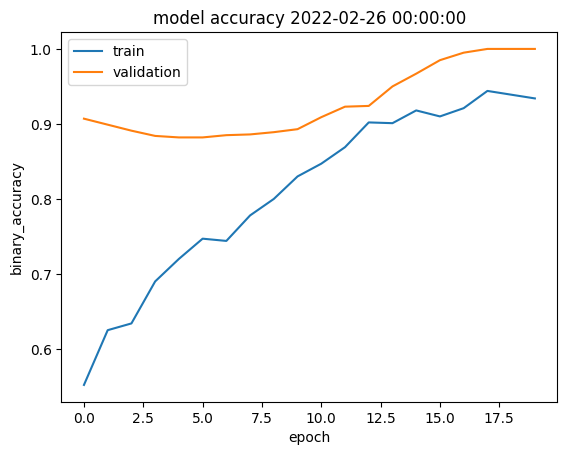

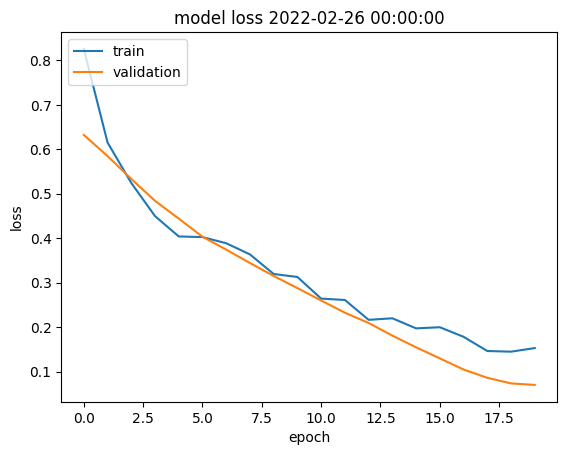

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/38 [========================>.....] - ETA: 0s - loss: 0.9504 - binary_accuracy: 0.4746

38/38 [==============================] - 3s 17ms/step - loss: 0.9406 - binary_accuracy: 0.4833 - val_loss: 0.7832 - val_binary_accuracy: 0.1217
Epoch 2/20
36/38 [===========================>..] - ETA: 0s - loss: 0.6163 - binary_accuracy: 0.5738

38/38 [==============================] - 0s 10ms/step - loss: 0.6114 - binary_accuracy: 0.5742 - val_loss: 0.8375 - val_binary_accuracy: 0.1208
Epoch 3/20
36/38 [===========================>..] - ETA: 0s - loss: 0.5238 - binary_accuracy: 0.6128

38/38 [==============================] - 0s 11ms/step - loss: 0.5237 - binary_accuracy: 0.6142 - val_loss: 0.8418 - val_binary_accuracy: 0.1233
Epoch 4/20
36/38 [===========================>..] - ETA: 0s - loss: 0.4601 - binary_accuracy: 0.6562

38/38 [==============================] - 0s 12ms/step - loss: 0.4601 - binary_accuracy: 0.6575 - val_loss: 0.7984 - val_binary_accuracy: 0.1517
Epoch 5/20
32/38 [========================>.....] - ETA: 0s - loss: 0.4460 - binary_accuracy: 0.6787

38/38 [==============================] - 0s 11ms/step - loss: 0.4434 - binary_accuracy: 0.6767 - val_loss: 0.7429 - val_binary_accuracy: 0.2833
Epoch 6/20
33/38 [=========================>....] - ETA: 0s - loss: 0.3926 - binary_accuracy: 0.7282

38/38 [==============================] - 0s 11ms/step - loss: 0.3852 - binary_accuracy: 0.7425 - val_loss: 0.6766 - val_binary_accuracy: 0.5408
Epoch 7/20
36/38 [===========================>..] - ETA: 0s - loss: 0.3683 - binary_accuracy: 0.7604

38/38 [==============================] - 0s 9ms/step - loss: 0.3651 - binary_accuracy: 0.7600 - val_loss: 0.6142 - val_binary_accuracy: 0.7350
Epoch 8/20
36/38 [===========================>..] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.7856

38/38 [==============================] - 0s 9ms/step - loss: 0.3329 - binary_accuracy: 0.7867 - val_loss: 0.5405 - val_binary_accuracy: 0.8658
Epoch 9/20
33/38 [=========================>....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8078

38/38 [==============================] - 0s 11ms/step - loss: 0.3119 - binary_accuracy: 0.8050 - val_loss: 0.4769 - val_binary_accuracy: 0.9150
Epoch 10/20
37/38 [============================>.] - ETA: 0s - loss: 0.2900 - binary_accuracy: 0.8294

38/38 [==============================] - 1s 14ms/step - loss: 0.2891 - binary_accuracy: 0.8300 - val_loss: 0.4146 - val_binary_accuracy: 0.9492
Epoch 11/20
33/38 [=========================>....] - ETA: 0s - loss: 0.2738 - binary_accuracy: 0.8494

38/38 [==============================] - 1s 15ms/step - loss: 0.2778 - binary_accuracy: 0.8500 - val_loss: 0.3500 - val_binary_accuracy: 0.9733
Epoch 12/20
34/38 [=========================>....] - ETA: 0s - loss: 0.2595 - binary_accuracy: 0.8594

38/38 [==============================] - 0s 13ms/step - loss: 0.2523 - binary_accuracy: 0.8642 - val_loss: 0.3098 - val_binary_accuracy: 0.9767
Epoch 13/20
34/38 [=========================>....] - ETA: 0s - loss: 0.2469 - binary_accuracy: 0.8796

38/38 [==============================] - 1s 14ms/step - loss: 0.2450 - binary_accuracy: 0.8808 - val_loss: 0.2471 - val_binary_accuracy: 0.9850
Epoch 14/20
38/38 [==============================] - ETA: 0s - loss: 0.2204 - binary_accuracy: 0.9117

38/38 [==============================] - 1s 16ms/step - loss: 0.2204 - binary_accuracy: 0.9117 - val_loss: 0.2166 - val_binary_accuracy: 0.9792
Epoch 15/20
35/38 [==========================>...] - ETA: 0s - loss: 0.1838 - binary_accuracy: 0.9098

38/38 [==============================] - 1s 16ms/step - loss: 0.1854 - binary_accuracy: 0.9075 - val_loss: 0.1536 - val_binary_accuracy: 0.9933
Epoch 16/20
38/38 [==============================] - ETA: 0s - loss: 0.1832 - binary_accuracy: 0.9125

38/38 [==============================] - 1s 17ms/step - loss: 0.1832 - binary_accuracy: 0.9125 - val_loss: 0.1336 - val_binary_accuracy: 0.9925
Epoch 17/20
34/38 [=========================>....] - ETA: 0s - loss: 0.1659 - binary_accuracy: 0.9210

38/38 [==============================] - 0s 11ms/step - loss: 0.1677 - binary_accuracy: 0.9225 - val_loss: 0.1123 - val_binary_accuracy: 0.9958
Epoch 18/20
31/38 [=======================>......] - ETA: 0s - loss: 0.1739 - binary_accuracy: 0.9264

38/38 [==============================] - 0s 11ms/step - loss: 0.1689 - binary_accuracy: 0.9292 - val_loss: 0.0824 - val_binary_accuracy: 0.9967
Epoch 19/20
31/38 [=======================>......] - ETA: 0s - loss: 0.1570 - binary_accuracy: 0.9405

38/38 [==============================] - 0s 11ms/step - loss: 0.1518 - binary_accuracy: 0.9358 - val_loss: 0.0727 - val_binary_accuracy: 0.9950
Epoch 20/20
32/38 [========================>.....] - ETA: 0s - loss: 0.1418 - binary_accuracy: 0.9355

38/38 [==============================] - 0s 3ms/step - loss: 0.0743 - binary_accuracy: 0.9950
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
38/38 [==============================] - 0s 3ms/step - loss: 0.0743 - binary_accuracy: 0.9950
Test Accuracy
38/38 [==============================] - 0s 3ms/step - loss: 0.0743 - binary_accuracy: 0.9950


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


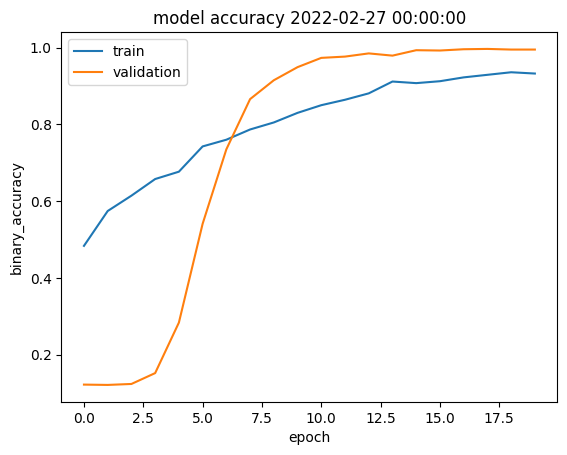

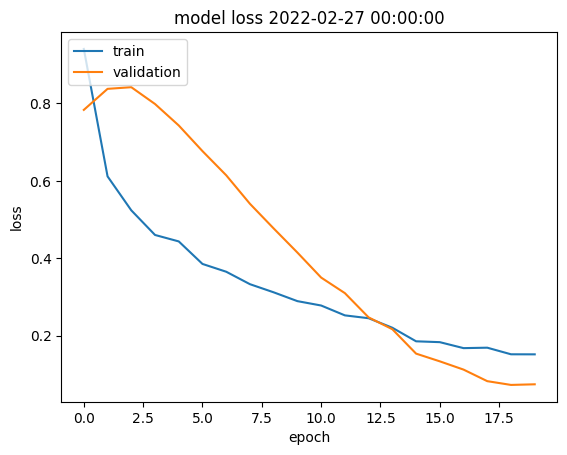

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


37/44 [========================>.....] - ETA: 0s - loss: 0.9266 - binary_accuracy: 0.5270

44/44 [==============================] - 3s 12ms/step - loss: 0.9195 - binary_accuracy: 0.5279 - val_loss: 0.6150 - val_binary_accuracy: 0.8850
Epoch 2/20
36/44 [=======================>......] - ETA: 0s - loss: 0.6584 - binary_accuracy: 0.5946

44/44 [==============================] - 0s 9ms/step - loss: 0.6424 - binary_accuracy: 0.6021 - val_loss: 0.5218 - val_binary_accuracy: 0.8771
Epoch 3/20
36/44 [=======================>......] - ETA: 0s - loss: 0.5507 - binary_accuracy: 0.6623

44/44 [==============================] - 0s 10ms/step - loss: 0.5398 - binary_accuracy: 0.6571 - val_loss: 0.4531 - val_binary_accuracy: 0.8771
Epoch 4/20
39/44 [=========================>....] - ETA: 0s - loss: 0.5296 - binary_accuracy: 0.6899

44/44 [==============================] - 1s 12ms/step - loss: 0.5113 - binary_accuracy: 0.6929 - val_loss: 0.4051 - val_binary_accuracy: 0.8771
Epoch 5/20
42/44 [===========================>..] - ETA: 0s - loss: 0.4593 - binary_accuracy: 0.7321

44/44 [==============================] - 1s 16ms/step - loss: 0.4574 - binary_accuracy: 0.7314 - val_loss: 0.3664 - val_binary_accuracy: 0.8771
Epoch 6/20
40/44 [==========================>...] - ETA: 0s - loss: 0.4152 - binary_accuracy: 0.7578

44/44 [==============================] - 1s 12ms/step - loss: 0.4284 - binary_accuracy: 0.7571 - val_loss: 0.3349 - val_binary_accuracy: 0.8779
Epoch 7/20
39/44 [=========================>....] - ETA: 0s - loss: 0.3918 - binary_accuracy: 0.7893

44/44 [==============================] - 1s 13ms/step - loss: 0.4022 - binary_accuracy: 0.7864 - val_loss: 0.3081 - val_binary_accuracy: 0.8843
Epoch 8/20
40/44 [==========================>...] - ETA: 0s - loss: 0.3792 - binary_accuracy: 0.8008

44/44 [==============================] - 1s 18ms/step - loss: 0.3728 - binary_accuracy: 0.8021 - val_loss: 0.2779 - val_binary_accuracy: 0.9000
Epoch 9/20
39/44 [=========================>....] - ETA: 0s - loss: 0.3005 - binary_accuracy: 0.8293

44/44 [==============================] - 1s 13ms/step - loss: 0.3063 - binary_accuracy: 0.8279 - val_loss: 0.2476 - val_binary_accuracy: 0.9121
Epoch 10/20
41/44 [==========================>...] - ETA: 0s - loss: 0.2945 - binary_accuracy: 0.8483

44/44 [==============================] - 1s 12ms/step - loss: 0.2947 - binary_accuracy: 0.8493 - val_loss: 0.2151 - val_binary_accuracy: 0.9329
Epoch 11/20
40/44 [==========================>...] - ETA: 0s - loss: 0.2991 - binary_accuracy: 0.8500

44/44 [==============================] - 0s 10ms/step - loss: 0.2988 - binary_accuracy: 0.8550 - val_loss: 0.1890 - val_binary_accuracy: 0.9614
Epoch 12/20
35/44 [======================>.......] - ETA: 0s - loss: 0.2789 - binary_accuracy: 0.8670

44/44 [==============================] - 0s 10ms/step - loss: 0.2895 - binary_accuracy: 0.8629 - val_loss: 0.1623 - val_binary_accuracy: 0.9793
Epoch 13/20
43/44 [============================>.] - ETA: 0s - loss: 0.2720 - binary_accuracy: 0.8743

44/44 [==============================] - 0s 9ms/step - loss: 0.2729 - binary_accuracy: 0.8736 - val_loss: 0.1450 - val_binary_accuracy: 0.9850
Epoch 14/20
38/44 [========================>.....] - ETA: 0s - loss: 0.2606 - binary_accuracy: 0.8914

44/44 [==============================] - 0s 10ms/step - loss: 0.2588 - binary_accuracy: 0.8864 - val_loss: 0.1389 - val_binary_accuracy: 0.9821
Epoch 15/20
41/44 [==========================>...] - ETA: 0s - loss: 0.2088 - binary_accuracy: 0.9062

44/44 [==============================] - 0s 11ms/step - loss: 0.2075 - binary_accuracy: 0.9071 - val_loss: 0.1159 - val_binary_accuracy: 0.9886
Epoch 16/20
39/44 [=========================>....] - ETA: 0s - loss: 0.2041 - binary_accuracy: 0.9062

44/44 [==============================] - 0s 11ms/step - loss: 0.2002 - binary_accuracy: 0.9071 - val_loss: 0.0944 - val_binary_accuracy: 0.9936
Epoch 17/20
43/44 [============================>.] - ETA: 0s - loss: 0.1846 - binary_accuracy: 0.9208

44/44 [==============================] - 0s 10ms/step - loss: 0.1876 - binary_accuracy: 0.9214 - val_loss: 0.0930 - val_binary_accuracy: 0.9929
Epoch 18/20
40/44 [==========================>...] - ETA: 0s - loss: 0.1852 - binary_accuracy: 0.9258

44/44 [==============================] - 0s 11ms/step - loss: 0.1896 - binary_accuracy: 0.9250 - val_loss: 0.0813 - val_binary_accuracy: 0.9921
Epoch 19/20
42/44 [===========================>..] - ETA: 0s - loss: 0.1664 - binary_accuracy: 0.9315

44/44 [==============================] - 0s 11ms/step - loss: 0.1677 - binary_accuracy: 0.9336 - val_loss: 0.0815 - val_binary_accuracy: 0.9921
Epoch 20/20
43/44 [============================>.] - ETA: 0s - loss: 0.1394 - binary_accuracy: 0.9455

44/44 [==============================] - 0s 3ms/step - loss: 0.0572 - binary_accuracy: 0.9950
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
44/44 [==============================] - 0s 3ms/step - loss: 0.0572 - binary_accuracy: 0.9950
Test Accuracy
44/44 [==============================] - 0s 3ms/step - loss: 0.0572 - binary_accuracy: 0.9950


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


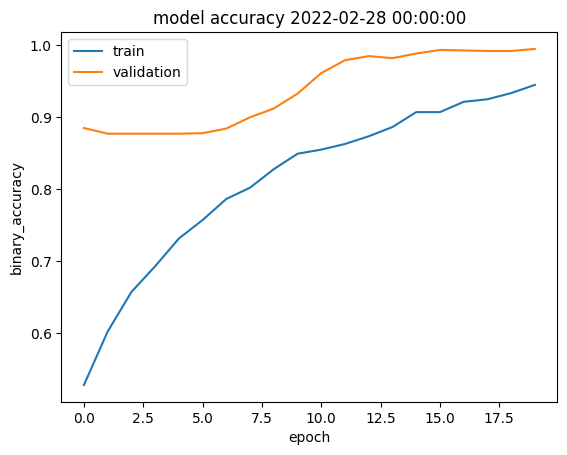

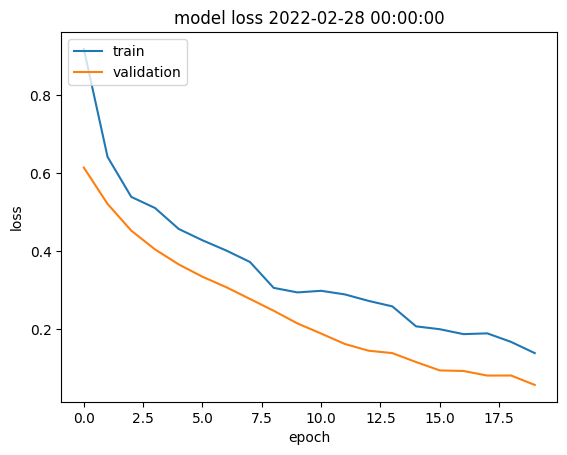

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


47/50 [===========================>..] - ETA: 0s - loss: 0.7424 - binary_accuracy: 0.5253

50/50 [==============================] - 2s 11ms/step - loss: 0.7311 - binary_accuracy: 0.5269 - val_loss: 0.7161 - val_binary_accuracy: 0.2256
Epoch 2/20
46/50 [==========================>...] - ETA: 0s - loss: 0.5904 - binary_accuracy: 0.5625

50/50 [==============================] - 0s 8ms/step - loss: 0.5830 - binary_accuracy: 0.5681 - val_loss: 0.7119 - val_binary_accuracy: 0.3019
Epoch 3/20
47/50 [===========================>..] - ETA: 0s - loss: 0.5049 - binary_accuracy: 0.6310

50/50 [==============================] - 0s 8ms/step - loss: 0.5070 - binary_accuracy: 0.6294 - val_loss: 0.6636 - val_binary_accuracy: 0.6300
Epoch 4/20
45/50 [==========================>...] - ETA: 0s - loss: 0.4758 - binary_accuracy: 0.6681

50/50 [==============================] - 0s 8ms/step - loss: 0.4706 - binary_accuracy: 0.6712 - val_loss: 0.6080 - val_binary_accuracy: 0.8288
Epoch 5/20
45/50 [==========================>...] - ETA: 0s - loss: 0.4391 - binary_accuracy: 0.7139

50/50 [==============================] - 0s 8ms/step - loss: 0.4341 - binary_accuracy: 0.7181 - val_loss: 0.5452 - val_binary_accuracy: 0.9087
Epoch 6/20
48/50 [===========================>..] - ETA: 0s - loss: 0.4188 - binary_accuracy: 0.7461

50/50 [==============================] - 0s 8ms/step - loss: 0.4195 - binary_accuracy: 0.7456 - val_loss: 0.4958 - val_binary_accuracy: 0.9200
Epoch 7/20
46/50 [==========================>...] - ETA: 0s - loss: 0.3629 - binary_accuracy: 0.7908

50/50 [==============================] - 0s 7ms/step - loss: 0.3581 - binary_accuracy: 0.7944 - val_loss: 0.4165 - val_binary_accuracy: 0.9469
Epoch 8/20
46/50 [==========================>...] - ETA: 0s - loss: 0.3342 - binary_accuracy: 0.8159

50/50 [==============================] - 0s 8ms/step - loss: 0.3327 - binary_accuracy: 0.8169 - val_loss: 0.3477 - val_binary_accuracy: 0.9556
Epoch 9/20
46/50 [==========================>...] - ETA: 0s - loss: 0.3125 - binary_accuracy: 0.8254

50/50 [==============================] - 0s 7ms/step - loss: 0.3142 - binary_accuracy: 0.8281 - val_loss: 0.3171 - val_binary_accuracy: 0.9669
Epoch 10/20
46/50 [==========================>...] - ETA: 0s - loss: 0.2938 - binary_accuracy: 0.8607

50/50 [==============================] - 0s 7ms/step - loss: 0.2939 - binary_accuracy: 0.8569 - val_loss: 0.2689 - val_binary_accuracy: 0.9700
Epoch 11/20
45/50 [==========================>...] - ETA: 0s - loss: 0.2645 - binary_accuracy: 0.8819

50/50 [==============================] - 0s 7ms/step - loss: 0.2692 - binary_accuracy: 0.8788 - val_loss: 0.2208 - val_binary_accuracy: 0.9688
Epoch 12/20
48/50 [===========================>..] - ETA: 0s - loss: 0.2559 - binary_accuracy: 0.8874

50/50 [==============================] - 0s 8ms/step - loss: 0.2532 - binary_accuracy: 0.8881 - val_loss: 0.1740 - val_binary_accuracy: 0.9781
Epoch 13/20
44/50 [=========================>....] - ETA: 0s - loss: 0.2368 - binary_accuracy: 0.8984

50/50 [==============================] - 0s 8ms/step - loss: 0.2333 - binary_accuracy: 0.8994 - val_loss: 0.1549 - val_binary_accuracy: 0.9794
Epoch 14/20
47/50 [===========================>..] - ETA: 0s - loss: 0.2224 - binary_accuracy: 0.8949

50/50 [==============================] - 0s 7ms/step - loss: 0.2202 - binary_accuracy: 0.8963 - val_loss: 0.1539 - val_binary_accuracy: 0.9712
Epoch 15/20
43/50 [========================>.....] - ETA: 0s - loss: 0.1755 - binary_accuracy: 0.9310

50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - binary_accuracy: 0.9325 - val_loss: 0.0963 - val_binary_accuracy: 0.9881
Epoch 16/20
43/50 [========================>.....] - ETA: 0s - loss: 0.1541 - binary_accuracy: 0.9360

50/50 [==============================] - 0s 8ms/step - loss: 0.1555 - binary_accuracy: 0.9369 - val_loss: 0.0927 - val_binary_accuracy: 0.9906
Epoch 17/20
47/50 [===========================>..] - ETA: 0s - loss: 0.1458 - binary_accuracy: 0.9428

50/50 [==============================] - 0s 7ms/step - loss: 0.1444 - binary_accuracy: 0.9438 - val_loss: 0.0790 - val_binary_accuracy: 0.9919
Epoch 18/20
47/50 [===========================>..] - ETA: 0s - loss: 0.1450 - binary_accuracy: 0.9561

50/50 [==============================] - 0s 7ms/step - loss: 0.1434 - binary_accuracy: 0.9569 - val_loss: 0.0707 - val_binary_accuracy: 0.9931
Epoch 19/20
45/50 [==========================>...] - ETA: 0s - loss: 0.1248 - binary_accuracy: 0.9493

50/50 [==============================] - 0s 7ms/step - loss: 0.1281 - binary_accuracy: 0.9506 - val_loss: 0.0684 - val_binary_accuracy: 0.9937
Epoch 20/20
49/50 [============================>.] - ETA: 0s - loss: 0.1348 - binary_accuracy: 0.9541

50/50 [==============================] - 0s 4ms/step - loss: 0.0572 - binary_accuracy: 0.9944
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
50/50 [==============================] - 0s 4ms/step - loss: 0.0572 - binary_accuracy: 0.9944
Test Accuracy
50/50 [==============================] - 0s 4ms/step - loss: 0.0572 - binary_accuracy: 0.9944


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


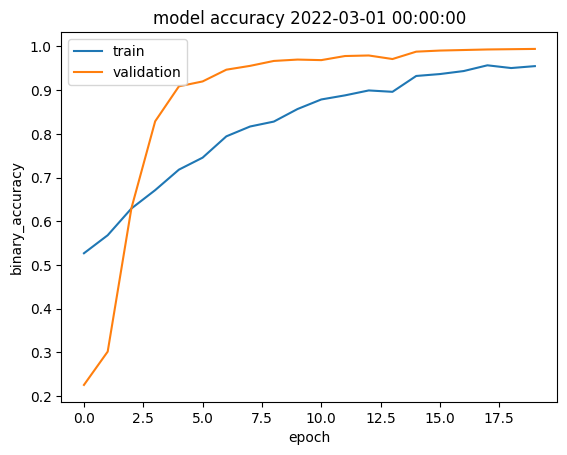

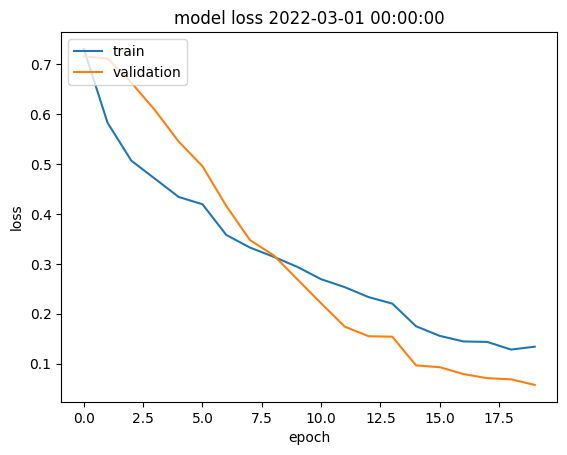

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/57 [==========================>...] - ETA: 0s - loss: 0.7258 - binary_accuracy: 0.5489

57/57 [==============================] - 3s 19ms/step - loss: 0.7300 - binary_accuracy: 0.5517 - val_loss: 0.6383 - val_binary_accuracy: 0.8917
Epoch 2/20
51/57 [=========================>....] - ETA: 0s - loss: 0.5600 - binary_accuracy: 0.6250

57/57 [==============================] - 1s 12ms/step - loss: 0.5580 - binary_accuracy: 0.6267 - val_loss: 0.5844 - val_binary_accuracy: 0.9072
Epoch 3/20
56/57 [============================>.] - ETA: 0s - loss: 0.5228 - binary_accuracy: 0.6574

57/57 [==============================] - 1s 15ms/step - loss: 0.5217 - binary_accuracy: 0.6578 - val_loss: 0.5318 - val_binary_accuracy: 0.9050
Epoch 4/20
54/57 [===========================>..] - ETA: 0s - loss: 0.4667 - binary_accuracy: 0.7112

57/57 [==============================] - 0s 8ms/step - loss: 0.4641 - binary_accuracy: 0.7122 - val_loss: 0.4851 - val_binary_accuracy: 0.9150
Epoch 5/20
52/57 [==========================>...] - ETA: 0s - loss: 0.4163 - binary_accuracy: 0.7428

57/57 [==============================] - 0s 9ms/step - loss: 0.4222 - binary_accuracy: 0.7406 - val_loss: 0.4191 - val_binary_accuracy: 0.9111
Epoch 6/20
52/57 [==========================>...] - ETA: 0s - loss: 0.4199 - binary_accuracy: 0.7692

57/57 [==============================] - 0s 8ms/step - loss: 0.4215 - binary_accuracy: 0.7706 - val_loss: 0.3688 - val_binary_accuracy: 0.9267
Epoch 7/20
52/57 [==========================>...] - ETA: 0s - loss: 0.3528 - binary_accuracy: 0.8131

57/57 [==============================] - 1s 9ms/step - loss: 0.3518 - binary_accuracy: 0.8144 - val_loss: 0.3178 - val_binary_accuracy: 0.9383
Epoch 8/20
54/57 [===========================>..] - ETA: 0s - loss: 0.3315 - binary_accuracy: 0.8304

57/57 [==============================] - 0s 8ms/step - loss: 0.3301 - binary_accuracy: 0.8283 - val_loss: 0.2728 - val_binary_accuracy: 0.9606
Epoch 9/20
53/57 [==========================>...] - ETA: 0s - loss: 0.3004 - binary_accuracy: 0.8620

57/57 [==============================] - 0s 8ms/step - loss: 0.3009 - binary_accuracy: 0.8594 - val_loss: 0.2242 - val_binary_accuracy: 0.9717
Epoch 10/20
57/57 [==============================] - ETA: 0s - loss: 0.2737 - binary_accuracy: 0.8706

57/57 [==============================] - 1s 9ms/step - loss: 0.2737 - binary_accuracy: 0.8706 - val_loss: 0.1975 - val_binary_accuracy: 0.9761
Epoch 11/20
52/57 [==========================>...] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.8864

57/57 [==============================] - 1s 9ms/step - loss: 0.2458 - binary_accuracy: 0.8844 - val_loss: 0.1674 - val_binary_accuracy: 0.9778
Epoch 12/20
56/57 [============================>.] - ETA: 0s - loss: 0.2403 - binary_accuracy: 0.8962

57/57 [==============================] - 0s 8ms/step - loss: 0.2403 - binary_accuracy: 0.8961 - val_loss: 0.1502 - val_binary_accuracy: 0.9811
Epoch 13/20
54/57 [===========================>..] - ETA: 0s - loss: 0.2314 - binary_accuracy: 0.8941

57/57 [==============================] - 1s 9ms/step - loss: 0.2282 - binary_accuracy: 0.8944 - val_loss: 0.1148 - val_binary_accuracy: 0.9839
Epoch 14/20
52/57 [==========================>...] - ETA: 0s - loss: 0.1878 - binary_accuracy: 0.9195

57/57 [==============================] - 1s 9ms/step - loss: 0.1910 - binary_accuracy: 0.9206 - val_loss: 0.0970 - val_binary_accuracy: 0.9906
Epoch 15/20
56/57 [============================>.] - ETA: 0s - loss: 0.2236 - binary_accuracy: 0.9118

57/57 [==============================] - 1s 10ms/step - loss: 0.2236 - binary_accuracy: 0.9122 - val_loss: 0.1137 - val_binary_accuracy: 0.9822
Epoch 16/20
54/57 [===========================>..] - ETA: 0s - loss: 0.1911 - binary_accuracy: 0.9352

57/57 [==============================] - 1s 9ms/step - loss: 0.1981 - binary_accuracy: 0.9322 - val_loss: 0.1060 - val_binary_accuracy: 0.9800
Epoch 17/20
54/57 [===========================>..] - ETA: 0s - loss: 0.1651 - binary_accuracy: 0.9306

57/57 [==============================] - 1s 9ms/step - loss: 0.1681 - binary_accuracy: 0.9322 - val_loss: 0.0773 - val_binary_accuracy: 0.9922
Epoch 18/20
56/57 [============================>.] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9342

57/57 [==============================] - 1s 9ms/step - loss: 0.1566 - binary_accuracy: 0.9339 - val_loss: 0.0616 - val_binary_accuracy: 0.9950
Epoch 19/20
54/57 [===========================>..] - ETA: 0s - loss: 0.1483 - binary_accuracy: 0.9462

57/57 [==============================] - 1s 9ms/step - loss: 0.1494 - binary_accuracy: 0.9428 - val_loss: 0.0529 - val_binary_accuracy: 0.9956
Epoch 20/20
55/57 [===========================>..] - ETA: 0s - loss: 0.1443 - binary_accuracy: 0.9426

57/57 [==============================] - 0s 3ms/step - loss: 0.0590 - binary_accuracy: 0.9928
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
57/57 [==============================] - 0s 3ms/step - loss: 0.0590 - binary_accuracy: 0.9928
Test Accuracy
57/57 [==============================] - 0s 3ms/step - loss: 0.0590 - binary_accuracy: 0.9928


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


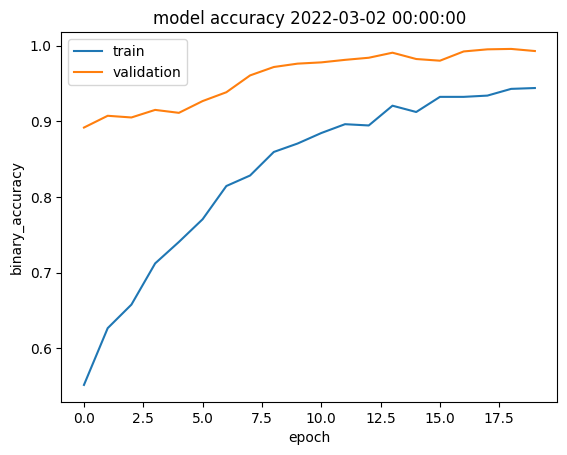

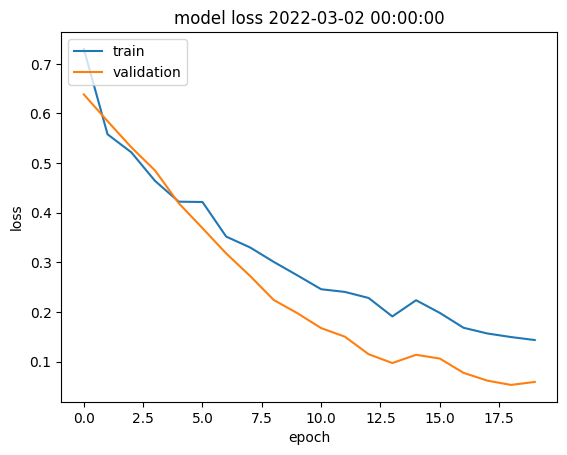

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - ETA: 0s - loss: 0.7137 - binary_accuracy: 0.5720

63/63 [==============================] - 2s 11ms/step - loss: 0.7137 - binary_accuracy: 0.5720 - val_loss: 0.6461 - val_binary_accuracy: 0.8925
Epoch 2/20
60/63 [===========================>..] - ETA: 0s - loss: 0.5940 - binary_accuracy: 0.6453

63/63 [==============================] - 1s 9ms/step - loss: 0.5945 - binary_accuracy: 0.6455 - val_loss: 0.5811 - val_binary_accuracy: 0.8925
Epoch 3/20
55/63 [=========================>....] - ETA: 0s - loss: 0.5117 - binary_accuracy: 0.7000

63/63 [==============================] - 1s 9ms/step - loss: 0.5179 - binary_accuracy: 0.7025 - val_loss: 0.5253 - val_binary_accuracy: 0.8940
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.4773 - binary_accuracy: 0.7385

63/63 [==============================] - 1s 10ms/step - loss: 0.4773 - binary_accuracy: 0.7385 - val_loss: 0.4805 - val_binary_accuracy: 0.8990
Epoch 5/20
62/63 [============================>.] - ETA: 0s - loss: 0.4297 - binary_accuracy: 0.7686

63/63 [==============================] - 1s 11ms/step - loss: 0.4297 - binary_accuracy: 0.7705 - val_loss: 0.4290 - val_binary_accuracy: 0.9080
Epoch 6/20
58/63 [==========================>...] - ETA: 0s - loss: 0.4107 - binary_accuracy: 0.7958

63/63 [==============================] - 1s 13ms/step - loss: 0.4080 - binary_accuracy: 0.7980 - val_loss: 0.3786 - val_binary_accuracy: 0.9175
Epoch 7/20
57/63 [==========================>...] - ETA: 0s - loss: 0.3673 - binary_accuracy: 0.8262

63/63 [==============================] - 1s 11ms/step - loss: 0.3687 - binary_accuracy: 0.8285 - val_loss: 0.3262 - val_binary_accuracy: 0.9505
Epoch 8/20
61/63 [============================>.] - ETA: 0s - loss: 0.3497 - binary_accuracy: 0.8397

63/63 [==============================] - 1s 14ms/step - loss: 0.3491 - binary_accuracy: 0.8400 - val_loss: 0.2790 - val_binary_accuracy: 0.9675
Epoch 9/20
62/63 [============================>.] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8614

63/63 [==============================] - 1s 12ms/step - loss: 0.3033 - binary_accuracy: 0.8615 - val_loss: 0.2304 - val_binary_accuracy: 0.9775
Epoch 10/20
57/63 [==========================>...] - ETA: 0s - loss: 0.2814 - binary_accuracy: 0.8805

63/63 [==============================] - 1s 8ms/step - loss: 0.2767 - binary_accuracy: 0.8825 - val_loss: 0.1957 - val_binary_accuracy: 0.9845
Epoch 11/20
59/63 [===========================>..] - ETA: 0s - loss: 0.2600 - binary_accuracy: 0.8919

63/63 [==============================] - 1s 8ms/step - loss: 0.2623 - binary_accuracy: 0.8930 - val_loss: 0.1877 - val_binary_accuracy: 0.9730
Epoch 12/20
57/63 [==========================>...] - ETA: 0s - loss: 0.2421 - binary_accuracy: 0.9112

63/63 [==============================] - 1s 8ms/step - loss: 0.2417 - binary_accuracy: 0.9125 - val_loss: 0.1346 - val_binary_accuracy: 0.9880
Epoch 13/20
62/63 [============================>.] - ETA: 0s - loss: 0.2063 - binary_accuracy: 0.9259

63/63 [==============================] - 1s 9ms/step - loss: 0.2059 - binary_accuracy: 0.9260 - val_loss: 0.1147 - val_binary_accuracy: 0.9875
Epoch 14/20
59/63 [===========================>..] - ETA: 0s - loss: 0.1943 - binary_accuracy: 0.9221

63/63 [==============================] - 1s 9ms/step - loss: 0.1984 - binary_accuracy: 0.9240 - val_loss: 0.1006 - val_binary_accuracy: 0.9890
Epoch 15/20
61/63 [============================>.] - ETA: 0s - loss: 0.1789 - binary_accuracy: 0.9319

63/63 [==============================] - 1s 9ms/step - loss: 0.1813 - binary_accuracy: 0.9300 - val_loss: 0.0961 - val_binary_accuracy: 0.9865
Epoch 16/20
63/63 [==============================] - ETA: 0s - loss: 0.1523 - binary_accuracy: 0.9500

63/63 [==============================] - 1s 8ms/step - loss: 0.1523 - binary_accuracy: 0.9500 - val_loss: 0.0870 - val_binary_accuracy: 0.9890
Epoch 17/20
55/63 [=========================>....] - ETA: 0s - loss: 0.1568 - binary_accuracy: 0.9472

63/63 [==============================] - 1s 8ms/step - loss: 0.1650 - binary_accuracy: 0.9460 - val_loss: 0.0762 - val_binary_accuracy: 0.9930
Epoch 18/20
63/63 [==============================] - ETA: 0s - loss: 0.1419 - binary_accuracy: 0.9475

63/63 [==============================] - 1s 9ms/step - loss: 0.1419 - binary_accuracy: 0.9475 - val_loss: 0.0686 - val_binary_accuracy: 0.9935
Epoch 19/20
61/63 [============================>.] - ETA: 0s - loss: 0.1509 - binary_accuracy: 0.9513

63/63 [==============================] - 1s 9ms/step - loss: 0.1487 - binary_accuracy: 0.9520 - val_loss: 0.0395 - val_binary_accuracy: 0.9980
Epoch 20/20
61/63 [============================>.] - ETA: 0s - loss: 0.1460 - binary_accuracy: 0.9457

63/63 [==============================] - 0s 3ms/step - loss: 0.0620 - binary_accuracy: 0.9925
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
63/63 [==============================] - 0s 3ms/step - loss: 0.0620 - binary_accuracy: 0.9925
Test Accuracy
63/63 [==============================] - 0s 3ms/step - loss: 0.0620 - binary_accuracy: 0.9925


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


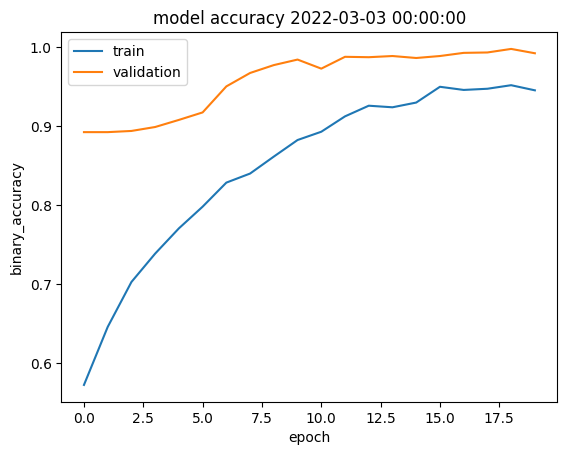

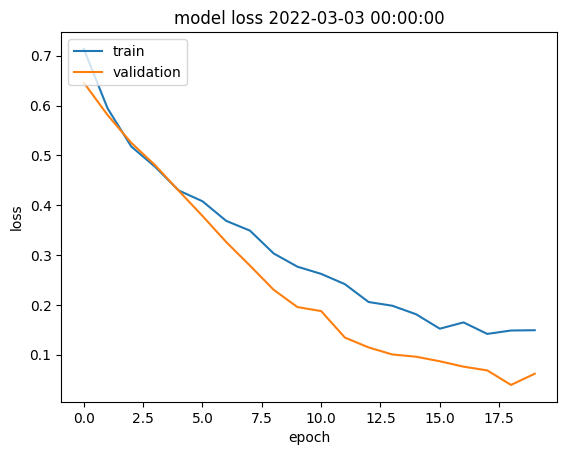

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


61/69 [=========================>....] - ETA: 0s - loss: 0.6958 - binary_accuracy: 0.5374

69/69 [==============================] - 3s 11ms/step - loss: 0.6885 - binary_accuracy: 0.5477 - val_loss: 0.7094 - val_binary_accuracy: 0.2359
Epoch 2/20
65/69 [===========================>..] - ETA: 0s - loss: 0.5512 - binary_accuracy: 0.6351

69/69 [==============================] - 1s 8ms/step - loss: 0.5495 - binary_accuracy: 0.6332 - val_loss: 0.6684 - val_binary_accuracy: 0.7132
Epoch 3/20
63/69 [==========================>...] - ETA: 0s - loss: 0.4895 - binary_accuracy: 0.6855

69/69 [==============================] - 1s 8ms/step - loss: 0.4913 - binary_accuracy: 0.6927 - val_loss: 0.6195 - val_binary_accuracy: 0.8632
Epoch 4/20
67/69 [============================>.] - ETA: 0s - loss: 0.4613 - binary_accuracy: 0.7201

69/69 [==============================] - 1s 8ms/step - loss: 0.4614 - binary_accuracy: 0.7232 - val_loss: 0.5509 - val_binary_accuracy: 0.9091
Epoch 5/20
69/69 [==============================] - ETA: 0s - loss: 0.4078 - binary_accuracy: 0.7632

69/69 [==============================] - 1s 9ms/step - loss: 0.4078 - binary_accuracy: 0.7632 - val_loss: 0.4627 - val_binary_accuracy: 0.9414
Epoch 6/20
64/69 [==========================>...] - ETA: 0s - loss: 0.3691 - binary_accuracy: 0.7993

69/69 [==============================] - 1s 8ms/step - loss: 0.3670 - binary_accuracy: 0.8027 - val_loss: 0.3850 - val_binary_accuracy: 0.9486
Epoch 7/20
65/69 [===========================>..] - ETA: 0s - loss: 0.3289 - binary_accuracy: 0.8284

69/69 [==============================] - 1s 8ms/step - loss: 0.3233 - binary_accuracy: 0.8332 - val_loss: 0.3122 - val_binary_accuracy: 0.9632
Epoch 8/20
61/69 [=========================>....] - ETA: 0s - loss: 0.2950 - binary_accuracy: 0.8607

69/69 [==============================] - 1s 8ms/step - loss: 0.2975 - binary_accuracy: 0.8623 - val_loss: 0.2432 - val_binary_accuracy: 0.9691
Epoch 9/20
66/69 [===========================>..] - ETA: 0s - loss: 0.2731 - binary_accuracy: 0.8878

69/69 [==============================] - 1s 8ms/step - loss: 0.2725 - binary_accuracy: 0.8873 - val_loss: 0.2087 - val_binary_accuracy: 0.9695
Epoch 10/20
68/69 [============================>.] - ETA: 0s - loss: 0.2422 - binary_accuracy: 0.8948

69/69 [==============================] - 1s 9ms/step - loss: 0.2447 - binary_accuracy: 0.8945 - val_loss: 0.1780 - val_binary_accuracy: 0.9686
Epoch 11/20
69/69 [==============================] - ETA: 0s - loss: 0.2185 - binary_accuracy: 0.9164

69/69 [==============================] - 1s 11ms/step - loss: 0.2185 - binary_accuracy: 0.9164 - val_loss: 0.1242 - val_binary_accuracy: 0.9841
Epoch 12/20
65/69 [===========================>..] - ETA: 0s - loss: 0.1836 - binary_accuracy: 0.9245

69/69 [==============================] - 1s 13ms/step - loss: 0.1896 - binary_accuracy: 0.9232 - val_loss: 0.1112 - val_binary_accuracy: 0.9818
Epoch 13/20
68/69 [============================>.] - ETA: 0s - loss: 0.2035 - binary_accuracy: 0.9260

69/69 [==============================] - 1s 13ms/step - loss: 0.2053 - binary_accuracy: 0.9264 - val_loss: 0.1374 - val_binary_accuracy: 0.9668
Epoch 14/20
65/69 [===========================>..] - ETA: 0s - loss: 0.1789 - binary_accuracy: 0.9394

69/69 [==============================] - 1s 12ms/step - loss: 0.1795 - binary_accuracy: 0.9400 - val_loss: 0.0961 - val_binary_accuracy: 0.9791
Epoch 15/20
69/69 [==============================] - ETA: 0s - loss: 0.1593 - binary_accuracy: 0.9409

69/69 [==============================] - 1s 13ms/step - loss: 0.1593 - binary_accuracy: 0.9409 - val_loss: 0.0980 - val_binary_accuracy: 0.9800
Epoch 16/20
63/69 [==========================>...] - ETA: 0s - loss: 0.1507 - binary_accuracy: 0.9380

69/69 [==============================] - 1s 9ms/step - loss: 0.1493 - binary_accuracy: 0.9382 - val_loss: 0.0604 - val_binary_accuracy: 0.9927
Epoch 17/20
62/69 [=========================>....] - ETA: 0s - loss: 0.1268 - binary_accuracy: 0.9496

69/69 [==============================] - 1s 8ms/step - loss: 0.1319 - binary_accuracy: 0.9514 - val_loss: 0.0590 - val_binary_accuracy: 0.9909
Epoch 18/20
69/69 [==============================] - ETA: 0s - loss: 0.1314 - binary_accuracy: 0.9555

69/69 [==============================] - 1s 9ms/step - loss: 0.1314 - binary_accuracy: 0.9555 - val_loss: 0.0420 - val_binary_accuracy: 0.9950
Epoch 19/20
69/69 [==============================] - ETA: 0s - loss: 0.1283 - binary_accuracy: 0.9514

69/69 [==============================] - 1s 9ms/step - loss: 0.1283 - binary_accuracy: 0.9514 - val_loss: 0.0523 - val_binary_accuracy: 0.9895
Epoch 20/20
68/69 [============================>.] - ETA: 0s - loss: 0.1169 - binary_accuracy: 0.9531

69/69 [==============================] - 0s 3ms/step - loss: 0.0345 - binary_accuracy: 0.9968
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
69/69 [==============================] - 0s 3ms/step - loss: 0.0345 - binary_accuracy: 0.9968
Test Accuracy
69/69 [==============================] - 0s 3ms/step - loss: 0.0345 - binary_accuracy: 0.9968


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


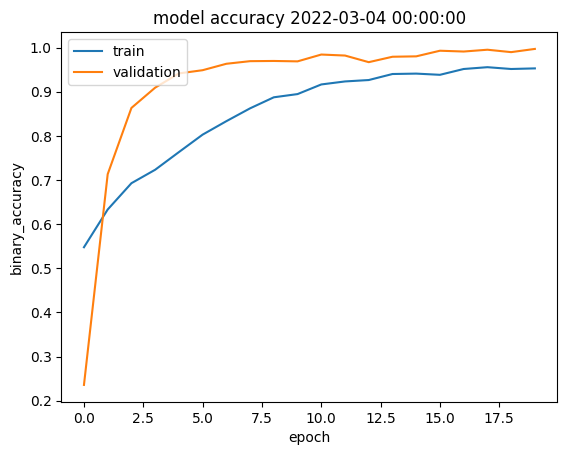

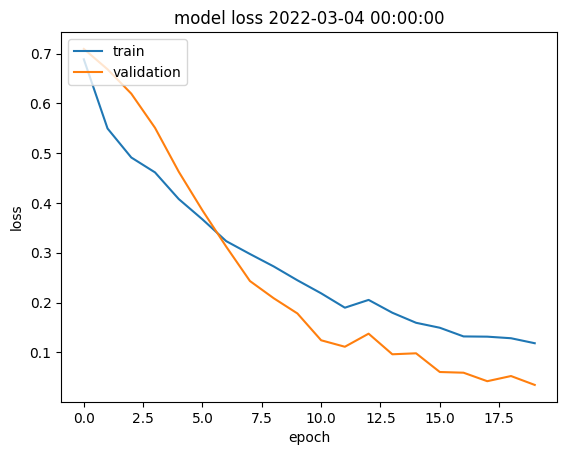

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


68/75 [==========================>...] - ETA: 0s - loss: 0.7493 - binary_accuracy: 0.5510

75/75 [==============================] - 2s 9ms/step - loss: 0.7411 - binary_accuracy: 0.5504 - val_loss: 0.6821 - val_binary_accuracy: 0.5446
Epoch 2/20
66/75 [=========================>....] - ETA: 0s - loss: 0.5605 - binary_accuracy: 0.6037

75/75 [==============================] - 1s 7ms/step - loss: 0.5576 - binary_accuracy: 0.6062 - val_loss: 0.6200 - val_binary_accuracy: 0.8654
Epoch 3/20
67/75 [=========================>....] - ETA: 0s - loss: 0.5211 - binary_accuracy: 0.6712

75/75 [==============================] - 1s 7ms/step - loss: 0.5220 - binary_accuracy: 0.6700 - val_loss: 0.5428 - val_binary_accuracy: 0.9187
Epoch 4/20
70/75 [===========================>..] - ETA: 0s - loss: 0.4445 - binary_accuracy: 0.7098

75/75 [==============================] - 1s 7ms/step - loss: 0.4464 - binary_accuracy: 0.7104 - val_loss: 0.4512 - val_binary_accuracy: 0.9296
Epoch 5/20
67/75 [=========================>....] - ETA: 0s - loss: 0.4135 - binary_accuracy: 0.7593

75/75 [==============================] - 1s 7ms/step - loss: 0.4103 - binary_accuracy: 0.7575 - val_loss: 0.3865 - val_binary_accuracy: 0.9388
Epoch 6/20
66/75 [=========================>....] - ETA: 0s - loss: 0.3799 - binary_accuracy: 0.7732

75/75 [==============================] - 1s 7ms/step - loss: 0.3809 - binary_accuracy: 0.7792 - val_loss: 0.3251 - val_binary_accuracy: 0.9538
Epoch 7/20
75/75 [==============================] - ETA: 0s - loss: 0.3434 - binary_accuracy: 0.8154

75/75 [==============================] - 1s 9ms/step - loss: 0.3434 - binary_accuracy: 0.8154 - val_loss: 0.2780 - val_binary_accuracy: 0.9529
Epoch 8/20
68/75 [==========================>...] - ETA: 0s - loss: 0.3204 - binary_accuracy: 0.8415

75/75 [==============================] - 1s 7ms/step - loss: 0.3213 - binary_accuracy: 0.8442 - val_loss: 0.2460 - val_binary_accuracy: 0.9463
Epoch 9/20
68/75 [==========================>...] - ETA: 0s - loss: 0.2877 - binary_accuracy: 0.8704

75/75 [==============================] - 1s 7ms/step - loss: 0.2876 - binary_accuracy: 0.8696 - val_loss: 0.1823 - val_binary_accuracy: 0.9654
Epoch 10/20
74/75 [============================>.] - ETA: 0s - loss: 0.2810 - binary_accuracy: 0.8708

75/75 [==============================] - 1s 7ms/step - loss: 0.2813 - binary_accuracy: 0.8704 - val_loss: 0.1736 - val_binary_accuracy: 0.9625
Epoch 11/20
66/75 [=========================>....] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.8883

75/75 [==============================] - 1s 7ms/step - loss: 0.2436 - binary_accuracy: 0.8892 - val_loss: 0.1744 - val_binary_accuracy: 0.9592
Epoch 12/20
68/75 [==========================>...] - ETA: 0s - loss: 0.2350 - binary_accuracy: 0.8980

75/75 [==============================] - 1s 7ms/step - loss: 0.2326 - binary_accuracy: 0.8950 - val_loss: 0.1726 - val_binary_accuracy: 0.9525
Epoch 13/20
67/75 [=========================>....] - ETA: 0s - loss: 0.2117 - binary_accuracy: 0.9072

75/75 [==============================] - 1s 7ms/step - loss: 0.2141 - binary_accuracy: 0.9071 - val_loss: 0.1034 - val_binary_accuracy: 0.9821
Epoch 14/20
67/75 [=========================>....] - ETA: 0s - loss: 0.1846 - binary_accuracy: 0.9254

75/75 [==============================] - 1s 7ms/step - loss: 0.1883 - binary_accuracy: 0.9200 - val_loss: 0.1038 - val_binary_accuracy: 0.9762
Epoch 15/20
66/75 [=========================>....] - ETA: 0s - loss: 0.1856 - binary_accuracy: 0.9219

75/75 [==============================] - 1s 7ms/step - loss: 0.1882 - binary_accuracy: 0.9237 - val_loss: 0.1053 - val_binary_accuracy: 0.9779
Epoch 16/20
66/75 [=========================>....] - ETA: 0s - loss: 0.1563 - binary_accuracy: 0.9351

75/75 [==============================] - 1s 10ms/step - loss: 0.1570 - binary_accuracy: 0.9308 - val_loss: 0.0832 - val_binary_accuracy: 0.9842
Epoch 17/20
75/75 [==============================] - ETA: 0s - loss: 0.1552 - binary_accuracy: 0.9433

75/75 [==============================] - 1s 10ms/step - loss: 0.1552 - binary_accuracy: 0.9433 - val_loss: 0.0830 - val_binary_accuracy: 0.9837
Epoch 18/20
75/75 [==============================] - ETA: 0s - loss: 0.1390 - binary_accuracy: 0.9425

75/75 [==============================] - 1s 11ms/step - loss: 0.1390 - binary_accuracy: 0.9425 - val_loss: 0.0747 - val_binary_accuracy: 0.9825
Epoch 19/20
74/75 [============================>.] - ETA: 0s - loss: 0.1397 - binary_accuracy: 0.9434

75/75 [==============================] - 1s 11ms/step - loss: 0.1385 - binary_accuracy: 0.9438 - val_loss: 0.0609 - val_binary_accuracy: 0.9875
Epoch 20/20
70/75 [===========================>..] - ETA: 0s - loss: 0.1355 - binary_accuracy: 0.9482

75/75 [==============================] - 0s 3ms/step - loss: 0.0538 - binary_accuracy: 0.9925
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
75/75 [==============================] - 0s 3ms/step - loss: 0.0538 - binary_accuracy: 0.9925
Test Accuracy
75/75 [==============================] - 0s 3ms/step - loss: 0.0538 - binary_accuracy: 0.9925


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


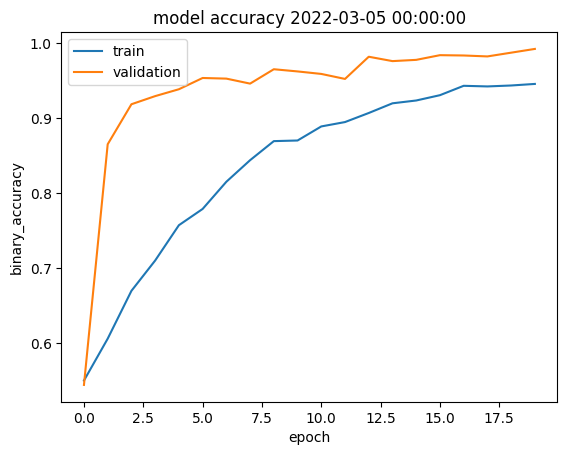

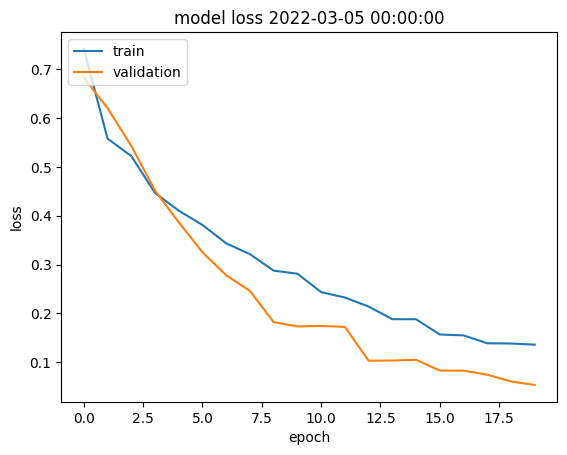

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


80/82 [============================>.] - ETA: 0s - loss: 0.7554 - binary_accuracy: 0.5887

82/82 [==============================] - 3s 10ms/step - loss: 0.7549 - binary_accuracy: 0.5892 - val_loss: 0.5398 - val_binary_accuracy: 0.8862
Epoch 2/20
74/82 [==========================>...] - ETA: 0s - loss: 0.5811 - binary_accuracy: 0.6596

82/82 [==============================] - 1s 9ms/step - loss: 0.5787 - binary_accuracy: 0.6631 - val_loss: 0.4370 - val_binary_accuracy: 0.8850
Epoch 3/20
78/82 [===========================>..] - ETA: 0s - loss: 0.5261 - binary_accuracy: 0.7188

82/82 [==============================] - 1s 8ms/step - loss: 0.5228 - binary_accuracy: 0.7185 - val_loss: 0.3901 - val_binary_accuracy: 0.8915
Epoch 4/20
80/82 [============================>.] - ETA: 0s - loss: 0.4658 - binary_accuracy: 0.7555

82/82 [==============================] - 1s 8ms/step - loss: 0.4705 - binary_accuracy: 0.7550 - val_loss: 0.3485 - val_binary_accuracy: 0.9092
Epoch 5/20
77/82 [===========================>..] - ETA: 0s - loss: 0.4287 - binary_accuracy: 0.7861

82/82 [==============================] - 1s 12ms/step - loss: 0.4295 - binary_accuracy: 0.7877 - val_loss: 0.3190 - val_binary_accuracy: 0.9262
Epoch 6/20
79/82 [===========================>..] - ETA: 0s - loss: 0.4074 - binary_accuracy: 0.8081

82/82 [==============================] - 1s 13ms/step - loss: 0.4052 - binary_accuracy: 0.8073 - val_loss: 0.2841 - val_binary_accuracy: 0.9350
Epoch 7/20
76/82 [==========================>...] - ETA: 0s - loss: 0.3856 - binary_accuracy: 0.8285

82/82 [==============================] - 1s 13ms/step - loss: 0.3812 - binary_accuracy: 0.8285 - val_loss: 0.2557 - val_binary_accuracy: 0.9446
Epoch 8/20
82/82 [==============================] - ETA: 0s - loss: 0.3398 - binary_accuracy: 0.8419

82/82 [==============================] - 1s 12ms/step - loss: 0.3398 - binary_accuracy: 0.8419 - val_loss: 0.2463 - val_binary_accuracy: 0.9438
Epoch 9/20
78/82 [===========================>..] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8562

82/82 [==============================] - 1s 10ms/step - loss: 0.3286 - binary_accuracy: 0.8546 - val_loss: 0.2119 - val_binary_accuracy: 0.9488
Epoch 10/20
78/82 [===========================>..] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8682

82/82 [==============================] - 1s 9ms/step - loss: 0.3114 - binary_accuracy: 0.8685 - val_loss: 0.1986 - val_binary_accuracy: 0.9523
Epoch 11/20
81/82 [============================>.] - ETA: 0s - loss: 0.2908 - binary_accuracy: 0.8727

82/82 [==============================] - 1s 10ms/step - loss: 0.2901 - binary_accuracy: 0.8731 - val_loss: 0.2097 - val_binary_accuracy: 0.9423
Epoch 12/20
78/82 [===========================>..] - ETA: 0s - loss: 0.2597 - binary_accuracy: 0.8930

82/82 [==============================] - 1s 10ms/step - loss: 0.2590 - binary_accuracy: 0.8927 - val_loss: 0.1383 - val_binary_accuracy: 0.9800
Epoch 13/20
80/82 [============================>.] - ETA: 0s - loss: 0.2524 - binary_accuracy: 0.8984

82/82 [==============================] - 1s 8ms/step - loss: 0.2542 - binary_accuracy: 0.8977 - val_loss: 0.1616 - val_binary_accuracy: 0.9615
Epoch 14/20
80/82 [============================>.] - ETA: 0s - loss: 0.2377 - binary_accuracy: 0.9066

82/82 [==============================] - 1s 8ms/step - loss: 0.2365 - binary_accuracy: 0.9069 - val_loss: 0.1191 - val_binary_accuracy: 0.9758
Epoch 15/20
81/82 [============================>.] - ETA: 0s - loss: 0.2087 - binary_accuracy: 0.9182

82/82 [==============================] - 1s 8ms/step - loss: 0.2099 - binary_accuracy: 0.9185 - val_loss: 0.1085 - val_binary_accuracy: 0.9738
Epoch 16/20
75/82 [==========================>...] - ETA: 0s - loss: 0.2039 - binary_accuracy: 0.9204

82/82 [==============================] - 1s 9ms/step - loss: 0.2035 - binary_accuracy: 0.9223 - val_loss: 0.0827 - val_binary_accuracy: 0.9900
Epoch 17/20
80/82 [============================>.] - ETA: 0s - loss: 0.1877 - binary_accuracy: 0.9242

82/82 [==============================] - 1s 10ms/step - loss: 0.1909 - binary_accuracy: 0.9238 - val_loss: 0.0924 - val_binary_accuracy: 0.9831
Epoch 18/20
82/82 [==============================] - ETA: 0s - loss: 0.1913 - binary_accuracy: 0.9288

82/82 [==============================] - 1s 8ms/step - loss: 0.1913 - binary_accuracy: 0.9288 - val_loss: 0.0945 - val_binary_accuracy: 0.9812
Epoch 19/20
76/82 [==========================>...] - ETA: 0s - loss: 0.1719 - binary_accuracy: 0.9350

82/82 [==============================] - 1s 10ms/step - loss: 0.1745 - binary_accuracy: 0.9338 - val_loss: 0.0634 - val_binary_accuracy: 0.9912
Epoch 20/20
76/82 [==========================>...] - ETA: 0s - loss: 0.1789 - binary_accuracy: 0.9363

82/82 [==============================] - 0s 3ms/step - loss: 0.0647 - binary_accuracy: 0.9908
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Train Accuracy
82/82 [==============================] - 0s 3ms/step - loss: 0.0647 - binary_accuracy: 0.9908
Test Accuracy
82/82 [==============================] - 0s 3ms/step - loss: 0.0647 - binary_accuracy: 0.9908


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


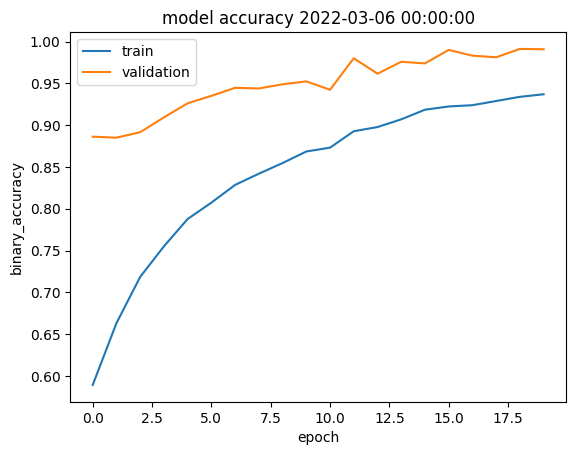

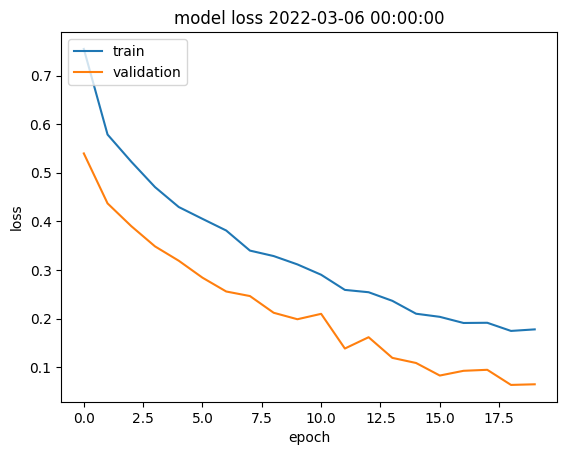

In [29]:

# Dict with all the labelled elements, every iteration it is filled with #{BUDGET} more labelled elements
labelled_elements = {}

x, y = [], []

for date in pd.date_range(min_date, max_date - pd.Timedelta(days=1)):
  curr = df[df.ts.dt.date == date.date()]
  next = df[df.ts.dt.date == (date + pd.Timedelta(days=1)).date()]


  # ACTIVE LEARNING PART: selecting which elements to use for training
  if AL_EFFICIENCY == "optimal":
    x.append(curr["embedding"])
    y.append(curr[LABEL])
  elif AL_EFFICIENCY == "normal":
    labelled_elements = al_methods[AL_METHOD](curr, labelled_elements, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  elif AL_EFFICIENCY == "forgetful":
    labelled_elements = al_methods[AL_METHOD](curr, {}, BUDGET, LABEL)
    x, y = list(labelled_elements.keys()), list(labelled_elements.values())
  else:
      x, y = [], []



  # Getting correct sets
  x_train, y_train, x_test, y_test, x_val, y_val = get_network_sets(x, y, next)

  # Creating model
  model, callback = create_model()

  # Calculating weights for better cnn performance
  class_weights = compute_class_weight(class_weight='balanced', classes=list(set(y)), y=y)
  class_weights = {class_index: weight for class_index, weight in enumerate(class_weights)}

  # Training model
  history = model.fit(x_train, y_train,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      verbose=1,
                      validation_data=([x_val, y_val]),
                      callbacks=callback,
                      class_weight=class_weights)

  # Evaluating Model
  model.evaluate(x_test, y_test, verbose=1)
  print(history.history.keys())

  print('Train Accuracy')
  model.evaluate(x_train, y_train)
  print('Test Accuracy')
  model.evaluate(x_test, y_test)
  history.history['binary_accuracy']

  model.save('prova.h5')

  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title(f'model accuracy {date}')
  plt.ylabel('binary_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(f'model loss {date}')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


### Example

In [1]:

examples = {"Ukraine's struggle: Lives lost, infrastructure shattered, and a haunting echo of war's relentless toll" : 1.0,
            "Immaculate bundles of joy, frolicking furballs with hearts full of love – that's the adorable charm of cute puppies" : 0.0,
            "Another day, another loss. Dionisi has to leave if Sassuolo wants to stay in Serie A #DionisiOUT #Empoli-Sassuolo #6-1" : 0.0,
            "Inter Milano has defeated Dynamo Kiev once again! ⚽️🔵⚫️ #InterMilan #ChampionsLeague" : 0.0,
            "Thoughts with Palestine during this difficult time, may the souls of the departed find tranquility in the afterlife 🕊️💔 #EternalPeace" : 1.0,
}

for text_example, label in examples.items():

  encoded_text = [embed_text(text_example)]
  encoded_text = np.array(encoded_text)

  output = model.predict(encoded_text)[0][0]

  print(f"Text: {text_example}\nDesired output: {decision(label)}\nActual output: {decision(output)} ({output})")


NameError: name 'embed_text' is not defined